 Portfolio Exam 3
      Reinforcement Learning BlackJack Player

Task P3.1
 Realize a Reinforcement Learning implementation of a self-learning BlackJack player in a program
ming language of your choice. This implementation provides the basis for the paper from Task P3.2.
 It shall learn optimal policies for at least the following scenarios:
 1. The Basic Strategy from [3].
 2. The Complete Point-Count System from [3].
 3. In addition to the basic rules, two rule variations of your choice shall be examined for their
 inuence on the strategies from (1.) and (2.).
 4. Consider improving the system from (2.) to be able to achieve higher pro ts on average.
 Note: Your system does not have to be suitable for humans. It may therefore be relatively
 complicated, e.g. with respect to card counting.

Basic strategy with random Action

1. Basic Strategy (Thorp) with Random Actions (No Learning)

Policy: Follow Thorp's Strategy with 10.0% random exploration.

FINAL RESULTS:
Wins: 297068 (29.71%) | Losses: 647440 (64.74%) | Draws: 55492 (5.55%)


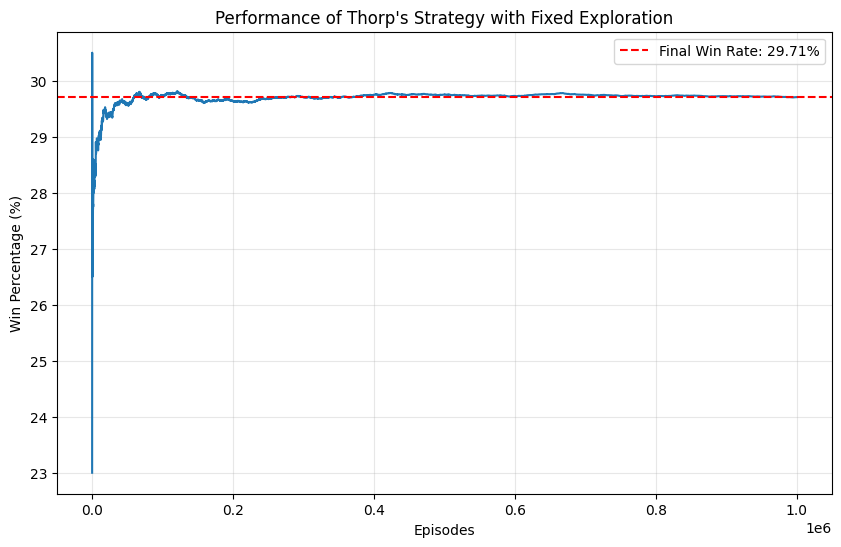

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import random
from collections import defaultdict
from typing import Tuple, List

# ===================================================================
# 1. ENVIRONMENT AND THORP STRATEGY DEFINITION
# ===================================================================

class BlackjackEnv:
    """Blackjack Environment with Double Down action."""

    def __init__(self):
        self.reset()

    def reset(self) -> Tuple[int, int, bool, bool]:
        """
        Resets the game:
        - Creates and shuffles a new deck
        - Deals 2 cards to player and dealer
        - Returns the initial state
        """
        self.deck = [2, 3, 4, 5, 6, 7, 8, 9, 10, 10, 10, 10, 11] * 4
        random.shuffle(self.deck)
        self.player_hand = [self.deck.pop(), self.deck.pop()]
        self.dealer_hand = [self.deck.pop(), self.deck.pop()]
        return self._get_state()

    def _get_hand_value(self, hand: List[int]) -> int:
        """
        Calculates total hand value, handling Aces as 1 or 11.
        """
        value = sum(hand)
        num_aces = hand.count(11)
        while value > 21 and num_aces > 0:
            value -= 10
            num_aces -= 1
        return value

    def _has_soft_ace(self, hand: List[int]) -> bool:
        """
        Checks if hand contains a soft Ace (Ace counted as 11 without busting).
        """
        return 11 in hand and self._get_hand_value(hand) <= 21

    def _get_state(self) -> Tuple[int, int, bool, bool]:
        """
        Returns the game state as a tuple:
        - Player hand value
        - Dealer's showing card
        - If player has a soft Ace
        - If player can Double Down
        """
        player_value = self._get_hand_value(self.player_hand)
        dealer_showing = self.dealer_hand[0]
        if dealer_showing == 11:
            dealer_showing = 1  # Treat Ace as 1 for dealer up card
        can_double = len(self.player_hand) == 2
        return (player_value, dealer_showing, self._has_soft_ace(self.player_hand), can_double)

    def step(self, action: int) -> Tuple[Tuple[int, int, bool, bool], int, bool]:
        """
        Takes an action:
        - 0: Stand
        - 1: Hit
        - 2: Double Down
        Returns: new state, reward, done flag
        """
        reward_multiplier = 1
        if action == 2:  # Double Down
            if len(self.player_hand) != 2:  # Illegal double down
                action = 1  # Treat as Hit
            else:
                reward_multiplier = 2

        if action == 1 or action == 2:  # Hit or Double Down
            self.player_hand.append(self.deck.pop())
            if self._get_hand_value(self.player_hand) > 21:
                return self._get_state(), -1 * reward_multiplier, True  # Player busts
            if action == 2:  # Double Down ends player's turn
                return self._dealer_turn(reward_multiplier)
            return self._get_state(), 0, False  # Continue playing
        else:  # Stand
            return self._dealer_turn(reward_multiplier)

    def _dealer_turn(self, reward_multiplier):
        """
        Runs dealer's turn:
        - Dealer hits until reaching 17 or more.
        - Computes final outcome.
        """
        while self._get_hand_value(self.dealer_hand) < 17:
            self.dealer_hand.append(self.deck.pop())

        player_value = self._get_hand_value(self.player_hand)
        dealer_value = self._get_hand_value(self.dealer_hand)

        reward = 0
        if dealer_value > 21 or player_value > dealer_value:
            reward = 1  # Player wins
        elif player_value < dealer_value:
            reward = -1  # Player loses
        # else: draw (reward stays 0)
        return self._get_state(), reward * reward_multiplier, True


class ThorpBasicStrategy:
    """Implements Edward O. Thorp's Basic Blackjack Strategy."""

    def __init__(self):
        # Action meanings:
        # 0 = Stand, 1 = Hit, 2 = Double Down

        # Basic strategy tables for hard and soft hands.
        self.hard_strategy = {
            11: {d: 2 for d in range(1, 11)},
            10: {d: 2 if d <= 9 else 1 for d in range(1, 11)},
            9:  {d: 2 if 3 <= d <= 6 else 1 for d in range(1, 11)},
            17: {d: 0 for d in range(1, 11)},
            16: {d: 0 if d <= 6 else 1 for d in range(1, 11)},
            15: {d: 0 if d <= 6 else 1 for d in range(1, 11)},
            14: {d: 0 if d <= 6 else 1 for d in range(1, 11)},
            13: {d: 0 if d <= 6 else 1 for d in range(1, 11)},
            12: {d: 1 if d <= 3 or d >= 7 else 0 for d in range(1, 11)},
        }
        self.soft_strategy = {
            19: {d: 0 for d in range(1, 11)},
            18: {d: 2 if 2 <= d <= 6 else (0 if d <= 8 else 1) for d in range(1, 11)},
            17: {d: 2 if 3 <= d <= 6 else 1 for d in range(1, 11)},
            16: {d: 2 if 4 <= d <= 6 else 1 for d in range(1, 11)},
            15: {d: 2 if 4 <= d <= 6 else 1 for d in range(1, 11)},
            14: {d: 2 if 5 <= d <= 6 else 1 for d in range(1, 11)},
            13: {d: 2 if 5 <= d <= 6 else 1 for d in range(1, 11)},
        }

    def get_action(self, state: Tuple[int, int, bool, bool]) -> int:
        """
        Returns action for given state using strategy table.
        """
        player_val, dealer_card, is_soft, can_double = state

        if player_val >= 20 and not is_soft:
            return 0  # Stand if hard 20 or 21
        if player_val <= 8:
            return 1  # Always hit on 8 or less

        table = self.soft_strategy if is_soft else self.hard_strategy
        action = table.get(player_val, {}).get(dealer_card, 1)  # Default to Hit

        if action == 2 and not can_double:
            return 1  # If can't Double Down, Hit instead

        return action


# ===================================================================
# 2. SIMULATION LOGIC
# ===================================================================

print("="*60)
print("1. Basic Strategy (Thorp) with Random Actions (No Learning)")
print("="*60)

EPSILON = 0.1  # 10% of the time take a random action (exploration)
NUM_EPISODES = 1_000_000

env = BlackjackEnv()
strategy = ThorpBasicStrategy()

# Tracking stats
wins, losses, draws = 0, 0, 0
win_rates, episodes_list = [], []

def get_mixed_action(state, strategy, epsilon):
    """
    Epsilon-greedy policy:
    - With prob epsilon: random action
    - Otherwise: follow strategy
    """
    if random.random() < epsilon:
        return random.choice([0, 1] if not state[3] else [0, 1, 2])
    return strategy.get_action(state)


for episode in range(NUM_EPISODES):
    state = env.reset()
    done = False
    while not done:
        action = get_mixed_action(state, strategy, EPSILON)
        state, reward, done = env.step(action)

    if reward > 0:
        wins += 1
    elif reward < 0:
        losses += 1
    else:
        draws += 1

    if (episode + 1) % 100 == 0:
        win_rates.append(wins / (episode + 1) * 100)
        episodes_list.append(episode + 1)

# ===================================================================
# 3. RESULTS
# ===================================================================

total_games = wins + losses + draws
win_p = (wins / total_games) * 100 if total_games > 0 else 0
loss_p = (losses / total_games) * 100 if total_games > 0 else 0
draw_p = (draws / total_games) * 100 if total_games > 0 else 0

print(f"\nPolicy: Follow Thorp's Strategy with {EPSILON*100}% random exploration.")
print("\nFINAL RESULTS:")
print(f"Wins: {wins} ({win_p:.2f}%) | Losses: {losses} ({loss_p:.2f}%) | Draws: {draws} ({draw_p:.2f}%)")

# Plot win rate over episodes
plt.figure(figsize=(10, 6))
plt.plot(episodes_list, win_rates)
plt.axhline(y=win_p, color='r', linestyle='--', label=f'Final Win Rate: {win_p:.2f}%')
plt.title("Performance of Thorp's Strategy with Fixed Exploration")
plt.xlabel('Episodes')
plt.ylabel('Win Percentage (%)')
plt.grid(True, alpha=0.3)
plt.legend()
plt.show()


Q-learning with basic stategy


Q-Learning with Thorp Strategy Baseline and Epsilon Plot

FINAL RESULTS:
Wins: 19478 (38.96%) | Losses: 26460 (52.92%) | Draws: 8.12%)


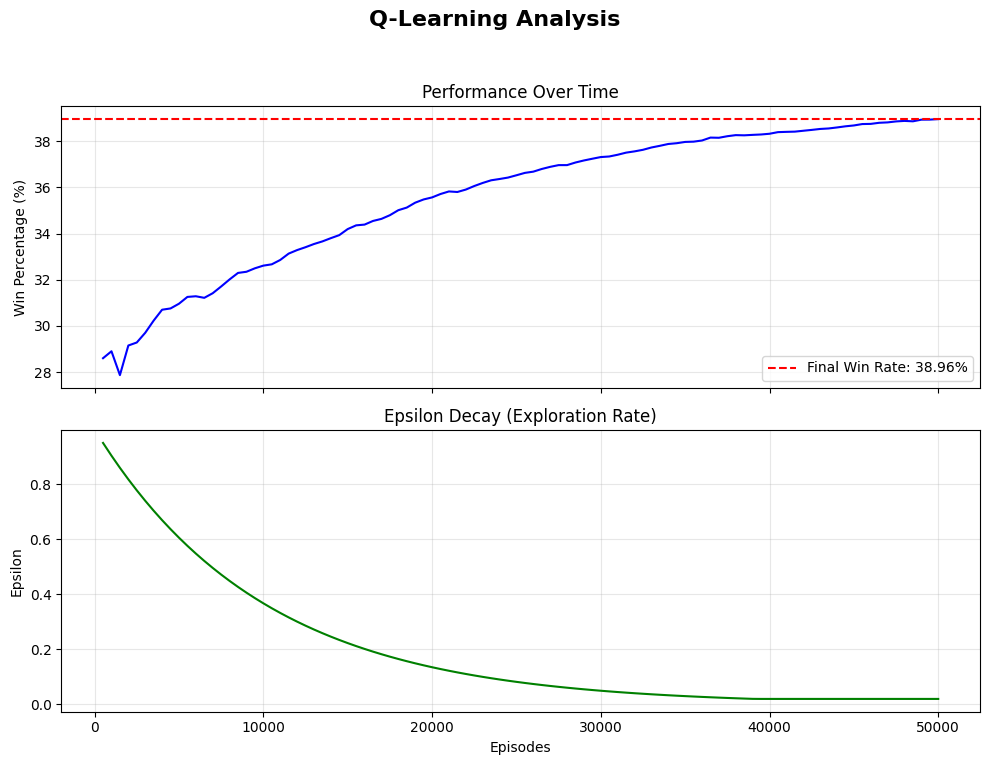

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import random
from collections import defaultdict
from typing import Tuple, List

# ===============================================================
# 1. ENVIRONMENT AND THORP STRATEGY DEFINITION
# ===============================================================

class BlackjackEnv:
    """Defines a simple Blackjack environment with a Double Down option."""

    def __init__(self):
        self.reset()  # Initialize by dealing cards

    def reset(self):
        """Reset the deck, shuffle, and deal two cards each to player and dealer."""
        self.deck = [2, 3, 4, 5, 6, 7, 8, 9, 10, 10, 10, 10, 11] * 4
        random.shuffle(self.deck)
        self.player_hand = [self.deck.pop(), self.deck.pop()]
        self.dealer_hand = [self.deck.pop(), self.deck.pop()]
        return self._get_state()

    def _get_hand_value(self, hand):
        """Compute the hand’s value, treating Aces as 1 or 11 optimally."""
        value = sum(hand)
        num_aces = hand.count(11)
        while value > 21 and num_aces > 0:
            value -= 10  # Convert Ace from 11 to 1 if busting
            num_aces -= 1
        return value

    def _has_soft_ace(self, hand):
        """Check if the hand has a usable Ace counted as 11."""
        return 11 in hand and self._get_hand_value(hand) <= 21

    def _get_state(self):
        """Return the current state: player value, dealer card, soft Ace, can double."""
        player_value = self._get_hand_value(self.player_hand)
        dealer_showing = self.dealer_hand[0]
        if dealer_showing == 11: dealer_showing = 1  # Treat dealer Ace as 1
        can_double = len(self.player_hand) == 2  # Can only double on first move
        return (player_value, dealer_showing, self._has_soft_ace(self.player_hand), can_double)

    def step(self, action):
        """
        Apply player action:
        0 = Stand
        1 = Hit
        2 = Double Down (Hit once, double bet, then stand)
        """
        reward_multiplier = 1
        if action == 2:
            if len(self.player_hand) != 2:
                action = 1  # Illegal double: treat as hit
            else:
                reward_multiplier = 2  # Double bet payout

        if action == 1 or action == 2:  # Hit or Double Down
            self.player_hand.append(self.deck.pop())
            if self._get_hand_value(self.player_hand) > 21:
                return self._get_state(), -1 * reward_multiplier, True  # Player busts
            if action == 2:
                return self._dealer_turn(reward_multiplier)  # Double ends turn
            return self._get_state(), 0, False  # Continue playing

        else:  # Stand
            return self._dealer_turn(reward_multiplier)

    def _dealer_turn(self, reward_multiplier):
        """Dealer draws until reaching 17 or higher, then resolve game outcome."""
        while self._get_hand_value(self.dealer_hand) < 17:
            self.dealer_hand.append(self.deck.pop())
        player_value = self._get_hand_value(self.player_hand)
        dealer_value = self._get_hand_value(self.dealer_hand)
        reward = 0
        if dealer_value > 21 or player_value > dealer_value:
            reward = 1  # Win
        elif player_value < dealer_value:
            reward = -1  # Lose
        return self._get_state(), reward * reward_multiplier, True


class ThorpBasicStrategy:
    """Implements Edward O. Thorp’s basic Blackjack strategy for Hard/Soft hands."""

    def __init__(self):
        # Hard hands strategy table: value -> dealer showing -> action
        self.hard_strategy = {
            11: {d: 2 for d in range(1, 11)},
            10: {d: 2 if d <= 9 else 1 for d in range(1, 11)},
            9:  {d: 2 if 3 <= d <= 6 else 1 for d in range(1, 11)},
            17: {d: 0 for d in range(1, 11)},
            16: {d: 0 if d <= 6 else 1 for d in range(1, 11)},
            15: {d: 0 if d <= 6 else 1 for d in range(1, 11)},
            14: {d: 0 if d <= 6 else 1 for d in range(1, 11)},
            13: {d: 0 if d <= 6 else 1 for d in range(1, 11)},
            12: {d: 1 if d <= 3 or d >= 7 else 0 for d in range(1, 11)},
        }
        # Soft hands strategy table
        self.soft_strategy = {
            19: {d: 0 for d in range(1, 11)},
            18: {d: 2 if 2 <= d <= 6 else (0 if d <= 8 else 1) for d in range(1, 11)},
            17: {d: 2 if 3 <= d <= 6 else 1 for d in range(1, 11)},
            16: {d: 2 if 4 <= d <= 6 else 1 for d in range(1, 11)},
            15: {d: 2 if 4 <= d <= 6 else 1 for d in range(1, 11)},
            14: {d: 2 if 5 <= d <= 6 else 1 for d in range(1, 11)},
            13: {d: 2 if 5 <= d <= 6 else 1 for d in range(1, 11)},
        }

    def get_action(self, state):
        """Return recommended action for given state from Thorp’s tables."""
        player_val, dealer_card, is_soft, can_double = state
        if player_val >= 20 and not is_soft:
            return 0  # Always stand at 20+
        if player_val <= 8:
            return 1  # Always hit below 8

        table = self.soft_strategy if is_soft else self.hard_strategy
        action = table.get(player_val, {}).get(dealer_card, 1)  # Default to hit

        if action == 2 and not can_double:
            return 1  # Can't double, so hit instead
        return action

# ===============================================================
# 2. Q-LEARNING SIMULATION LOGIC
# ===============================================================

print("\n" + "="*60)
print("Q-Learning with Thorp Strategy Baseline and Epsilon Plot")
print("="*60)

# Hyperparameters
LEARNING_RATE = 0.1
INITIAL_EPSILON = 1.0
EPSILON_DECAY = 0.9999
MIN_EPSILON = 0.02
GAMMA = 0.95
NUM_EPISODES = 50000

# Initialize environment, strategy, Q-table, and stats
env_q = BlackjackEnv()
strategy_q = ThorpBasicStrategy()
Q_q = defaultdict(lambda: defaultdict(float))
epsilon = INITIAL_EPSILON

wins_q, losses_q, draws_q = 0, 0, 0
win_rates_q, episodes_list_q, epsilons_q = [], [], []  # To plot epsilon

def get_legal_actions(state):
    """Return list of legal actions based on whether double is allowed."""
    return [0, 1, 2] if state[3] else [0, 1]

def epsilon_greedy_action(state, Q, epsilon, strategy):
    """Choose action using epsilon-greedy policy with fallback to Thorp strategy."""
    legal_actions = get_legal_actions(state)
    if random.random() < epsilon:
        return random.choice(legal_actions)
    q_vals = {a: Q[state][a] for a in legal_actions}
    max_q = max(q_vals.values())
    best_actions = [a for a, q in q_vals.items() if q == max_q]
    if len(best_actions) == 1:
        return best_actions[0]
    return strategy.get_action(state)  # Tiebreak using Thorp strategy

# Q-learning loop
for episode in range(NUM_EPISODES):
    state = env_q.reset()
    done = False
    while not done:
        action = epsilon_greedy_action(state, Q_q, epsilon, strategy_q)
        next_state, reward, done = env_q.step(action)
        best_next_q = max([Q_q[next_state][a] for a in get_legal_actions(next_state)]) if not done else 0
        Q_q[state][action] += LEARNING_RATE * (reward + GAMMA * best_next_q - Q_q[state][action])
        state = next_state

    # Track results
    if reward > 0: wins_q += 1
    elif reward < 0: losses_q += 1
    else: draws_q += 1

    # Decay epsilon
    epsilon = max(MIN_EPSILON, epsilon * EPSILON_DECAY)

    # Save stats for plotting
    if (episode + 1) % 500 == 0:
        win_rates_q.append(wins_q / (episode + 1) * 100)
        episodes_list_q.append(episode + 1)
        epsilons_q.append(epsilon)

# ===============================================================
# 3. RESULTS AND PLOTS
# ===============================================================

total_games = wins_q + losses_q + draws_q
win_p = (wins_q / total_games) * 100 if total_games > 0 else 0
loss_p = (losses_q / total_games) * 100 if total_games > 0 else 0
draw_p = (draws_q / total_games) * 100 if total_games > 0 else 0

print("\nFINAL RESULTS:")
print(f"Wins: {wins_q} ({win_p:.2f}%) | Losses: {losses_q} ({loss_p:.2f}%) | Draws: {draw_p:.2f}%)")

# Plot win rate and epsilon decay
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 8), sharex=True)
fig.suptitle('Q-Learning Analysis', fontsize=16, fontweight='bold')

ax1.plot(episodes_list_q, win_rates_q, color='b')
ax1.axhline(y=win_p, color='r', linestyle='--', label=f'Final Win Rate: {win_p:.2f}%')
ax1.set_ylabel('Win Percentage (%)')
ax1.set_title('Performance Over Time')
ax1.grid(True, alpha=0.3)
ax1.legend()

ax2.plot(episodes_list_q, epsilons_q, color='g')
ax2.set_xlabel('Episodes')
ax2.set_ylabel('Epsilon')
ax2.set_title('Epsilon Decay (Exploration Rate)')
ax2.grid(True, alpha=0.3)

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()


SARSA with Basic strategy


SARSA with Thorp Strategy Baseline and Epsilon Plot

FINAL RESULTS:
Wins: 40565 (40.56%) | Losses: 51213 (51.21%) | Draws: 8222 (8.22%)


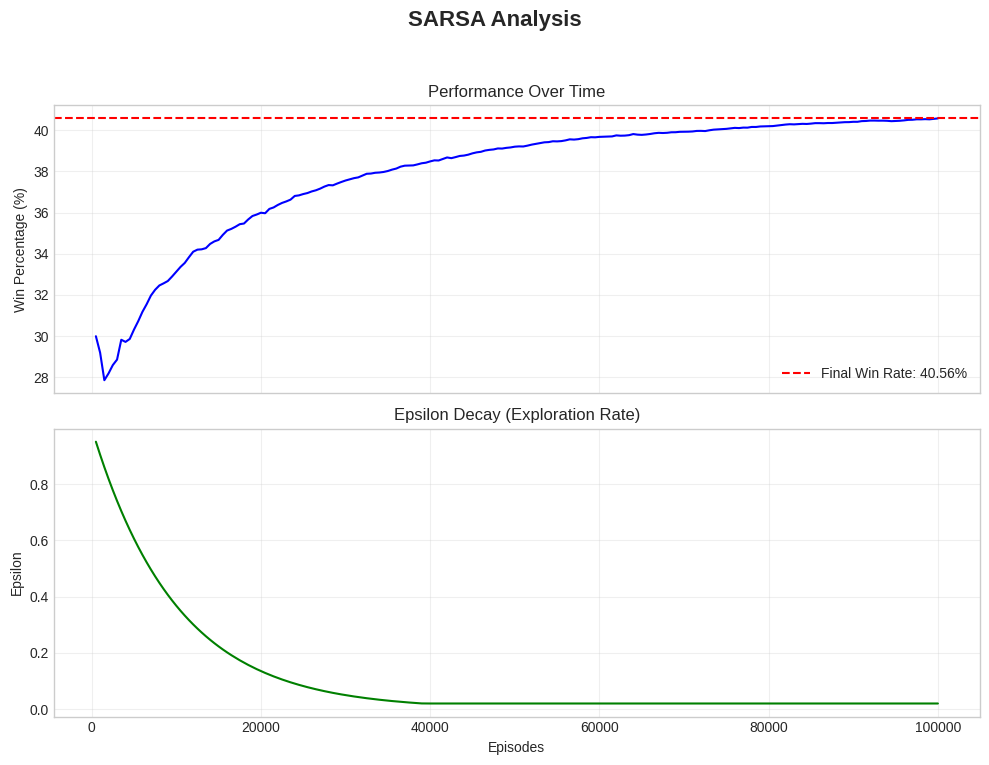

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import random
from collections import defaultdict
from typing import Tuple, List

# ===================================================================
# 1. ENVIRONMENT AND THORP STRATEGY DEFINITION (Same as above)
# ===================================================================

class BlackjackEnv:
    """Blackjack environment with Hit, Stand, Double Down actions."""
    def __init__(self):
        self.reset()

    def reset(self):
        """Initialize and shuffle deck, deal initial hands, return initial state."""
        self.deck = [2, 3, 4, 5, 6, 7, 8, 9, 10, 10, 10, 10, 11] * 4
        random.shuffle(self.deck)
        self.player_hand = [self.deck.pop(), self.deck.pop()]
        self.dealer_hand = [self.deck.pop(), self.deck.pop()]
        return self._get_state()

    def _get_hand_value(self, hand):
        """Compute best hand value, treating Aces as 1 or 11."""
        value = sum(hand)
        num_aces = hand.count(11)
        while value > 21 and num_aces > 0:
            value -= 10
            num_aces -= 1
        return value

    def _has_soft_ace(self, hand):
        """Check if hand is soft (has usable Ace)."""
        return 11 in hand and self._get_hand_value(hand) <= 21

    def _get_state(self):
        """Return current game state: (player total, dealer upcard, soft ace flag, double available)."""
        player_value = self._get_hand_value(self.player_hand)
        dealer_showing = self.dealer_hand[0]
        if dealer_showing == 11:
            dealer_showing = 1  # treat dealer Ace as 1 for strategy table
        can_double = len(self.player_hand) == 2
        return (player_value, dealer_showing, self._has_soft_ace(self.player_hand), can_double)

    def step(self, action):
        """
        Take action:
            0 = Stand
            1 = Hit
            2 = Double Down (if available)
        Returns: (new_state, reward, done)
        """
        reward_multiplier = 1
        if action == 2:
            if len(self.player_hand) != 2:
                action = 1  # fallback to Hit if Double not allowed
            else:
                reward_multiplier = 2

        if action in [1, 2]:
            self.player_hand.append(self.deck.pop())
            if self._get_hand_value(self.player_hand) > 21:
                return self._get_state(), -1 * reward_multiplier, True  # player bust
            if action == 2:
                return self._dealer_turn(reward_multiplier)  # Double -> one card then stand
            return self._get_state(), 0, False  # continue playing

        else:
            return self._dealer_turn(reward_multiplier)  # Stand

    def _dealer_turn(self, reward_multiplier):
        """Dealer plays until >=17. Determine outcome and apply multiplier."""
        while self._get_hand_value(self.dealer_hand) < 17:
            self.dealer_hand.append(self.deck.pop())
        player_value = self._get_hand_value(self.player_hand)
        dealer_value = self._get_hand_value(self.dealer_hand)

        reward = 0
        if dealer_value > 21 or player_value > dealer_value:
            reward = 1
        elif player_value < dealer_value:
            reward = -1

        return self._get_state(), reward * reward_multiplier, True

class ThorpBasicStrategy:
    """Edward Thorp's basic Blackjack strategy with double down logic."""
    def __init__(self):
        # Hard totals strategy
        self.hard_strategy = {
            11: {d: 2 for d in range(1, 11)},
            10: {d: 2 if d <= 9 else 1 for d in range(1, 11)},
            9:  {d: 2 if 3 <= d <= 6 else 1 for d in range(1, 11)},
            17: {d: 0 for d in range(1, 11)},
            16: {d: 0 if d <= 6 else 1 for d in range(1, 11)},
            15: {d: 0 if d <= 6 else 1 for d in range(1, 11)},
            14: {d: 0 if d <= 6 else 1 for d in range(1, 11)},
            13: {d: 0 if d <= 6 else 1 for d in range(1, 11)},
            12: {d: 1 if d <= 3 or d >= 7 else 0 for d in range(1, 11)},
        }
        # Soft totals strategy
        self.soft_strategy = {
            19: {d: 0 for d in range(1, 11)},
            18: {d: 2 if 2 <= d <= 6 else (0 if d <= 8 else 1) for d in range(1, 11)},
            17: {d: 2 if 3 <= d <= 6 else 1 for d in range(1, 11)},
            16: {d: 2 if 4 <= d <= 6 else 1 for d in range(1, 11)},
            15: {d: 2 if 4 <= d <= 6 else 1 for d in range(1, 11)},
            14: {d: 2 if 5 <= d <= 6 else 1 for d in range(1, 11)},
            13: {d: 2 if 5 <= d <= 6 else 1 for d in range(1, 11)},
        }

    def get_action(self, state):
        """Return action (0=Stand, 1=Hit, 2=Double) based on strategy tables."""
        player_val, dealer_card, is_soft, can_double = state

        if player_val >= 20 and not is_soft:
            return 0  # Stand on 20+
        if player_val <= 8:
            return 1  # Always hit <= 8

        table = self.soft_strategy if is_soft else self.hard_strategy
        action = table.get(player_val, {}).get(dealer_card, 1)

        if action == 2 and not can_double:
            return 1  # fallback if double not allowed
        return action

# ===================================================================
# 2. SARSA SIMULATION LOGIC
# ===================================================================

print("\n" + "="*60)
print("SARSA with Thorp Strategy Baseline and Epsilon Plot")
print("="*60)

# SARSA hyperparameters
LEARNING_RATE = 0.1
INITIAL_EPSILON = 1.0
EPSILON_DECAY = 0.9999
MIN_EPSILON = 0.02
GAMMA = 0.95
NUM_EPISODES = 100000

env_s, strategy_s = BlackjackEnv(), ThorpBasicStrategy()
Q_s = defaultdict(lambda: defaultdict(float))

epsilon = INITIAL_EPSILON
wins_s, losses_s, draws_s = 0, 0, 0
win_rates_s, episodes_list_s, epsilons_s = [], [], []  # store stats for plotting

def get_legal_actions(state):
    """Return list of allowed actions for the state."""
    return [0, 1, 2] if state[3] else [0, 1]

def epsilon_greedy_action(state, Q, epsilon, strategy):
    """
    Choose action using epsilon-greedy policy.
    Use Thorp strategy to break ties.
    """
    legal_actions = get_legal_actions(state)
    if random.random() < epsilon:
        return random.choice(legal_actions)
    q_vals = {a: Q[state][a] for a in legal_actions}
    max_q = max(q_vals.values())
    best_actions = [a for a, q in q_vals.items() if q == max_q]
    if len(best_actions) == 1:
        return best_actions[0]
    return strategy.get_action(state)

# SARSA training loop
for episode in range(NUM_EPISODES):
    state = env_s.reset()
    action = epsilon_greedy_action(state, Q_s, epsilon, strategy_s)
    done = False

    while not done:
        next_state, reward, done = env_s.step(action)
        next_action = epsilon_greedy_action(next_state, Q_s, epsilon, strategy_s)
        target_q = Q_s[next_state][next_action] if not done else 0
        Q_s[state][action] += LEARNING_RATE * (reward + GAMMA * target_q - Q_s[state][action])
        state, action = next_state, next_action

    # Record result
    if reward > 0:
        wins_s += 1
    elif reward < 0:
        losses_s += 1
    else:
        draws_s += 1

    # Decay epsilon
    epsilon = max(MIN_EPSILON, epsilon * EPSILON_DECAY)

    # Save stats every 500 episodes
    if (episode + 1) % 500 == 0:
        win_rates_s.append(wins_s / (episode + 1) * 100)
        episodes_list_s.append(episode + 1)
        epsilons_s.append(epsilon)

# ===================================================================
# 3. RESULTS
# ===================================================================

total_games = wins_s + losses_s + draws_s
win_p = (wins_s / total_games) * 100 if total_games > 0 else 0
loss_p = (losses_s / total_games) * 100 if total_games > 0 else 0
draw_p = (draws_s / total_games) * 100 if total_games > 0 else 0

print("\nFINAL RESULTS:")
print(f"Wins: {wins_s} ({win_p:.2f}%) | Losses: {losses_s} ({loss_p:.2f}%) | Draws: {draws_s} ({draw_p:.2f}%)")

# ===================================================================
# 4. PLOT RESULTS
# ===================================================================

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 8), sharex=True)
fig.suptitle('SARSA Analysis', fontsize=16, fontweight='bold')

# Plot win rate
ax1.plot(episodes_list_s, win_rates_s, color='b')
ax1.axhline(y=win_p, color='r', linestyle='--', label=f'Final Win Rate: {win_p:.2f}%')
ax1.set_ylabel('Win Percentage (%)')
ax1.set_title('Performance Over Time')
ax1.grid(True, alpha=0.3)
ax1.legend()

# Plot epsilon decay
ax2.plot(episodes_list_s, epsilons_s, color='g')
ax2.set_xlabel('Episodes')
ax2.set_ylabel('Epsilon')
ax2.set_title('Epsilon Decay (Exploration Rate)')
ax2.grid(True, alpha=0.3)

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()


Blackjack envirnment with rule variations (basic strategy)

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import random
from collections import defaultdict
from typing import Tuple, List

class BlackjackEnvWithVariations:
    """
    Blackjack environment that allows for rule variations:
    - Dealer hits on soft 17 (optional)
    - Double down allowed or not
    """
    def __init__(self, dealer_hits_on_soft_17: bool = False, allow_double_down: bool = True):
        self.dealer_hits_on_soft_17 = dealer_hits_on_soft_17  # Whether dealer hits on soft 17
        self.allow_double_down = allow_double_down            # Whether double down is allowed
        self.reset()                                          # Initialize a new game

    def reset(self) -> Tuple[int, int, bool, bool]:
        """Shuffles deck and deals initial hands."""
        self.deck = [2, 3, 4, 5, 6, 7, 8, 9, 10, 10, 10, 10, 11] * 4  # Standard blackjack deck
        random.shuffle(self.deck)
        self.player_hand = [self.deck.pop(), self.deck.pop()]  # Deal 2 cards to player
        self.dealer_hand = [self.deck.pop(), self.deck.pop()]  # Deal 2 cards to dealer
        return self._get_state()                               # Return initial state

    def _get_hand_value(self, hand: List[int]) -> int:
        """Calculate hand value, handling aces."""
        value = sum(hand)
        num_aces = hand.count(11)
        while value > 21 and num_aces > 0:
            value -= 10  # Convert Ace from 11 to 1
            num_aces -= 1
        return value

    def _has_soft_ace(self, hand: List[int]) -> bool:
        """Check if hand has a usable soft ace."""
        return 11 in hand and self._get_hand_value(hand) <= 21

    def _get_state(self) -> Tuple[int, int, bool, bool]:
        """
        Return current game state:
        - player's total value
        - dealer's upcard (Aces shown as 1)
        - whether player has a soft ace
        - whether player can double down
        """
        player_value = self._get_hand_value(self.player_hand)
        dealer_showing = self.dealer_hand[0]
        if dealer_showing == 11: dealer_showing = 1
        can_double = self.allow_double_down and len(self.player_hand) == 2
        return (player_value, dealer_showing, self._has_soft_ace(self.player_hand), can_double)

    def step(self, action: int) -> Tuple[Tuple[int, int, bool, bool], int, bool]:
        """
        Apply player's action.
        Actions:
        0 = Stand
        1 = Hit
        2 = Double Down (if allowed)
        Returns: next_state, reward, done
        """
        reward_multiplier = 1  # Double down doubles payout
        if action == 2:  # Double Down
            if not (self.allow_double_down and len(self.player_hand) == 2):
                action = 1  # Treat illegal double as hit
            else:
                reward_multiplier = 2

        if action == 1 or action == 2:  # Hit or legal Double
            self.player_hand.append(self.deck.pop())
            if self._get_hand_value(self.player_hand) > 21:
                return self._get_state(), -1 * reward_multiplier, True  # Bust
            if action == 2:
                return self._dealer_turn(reward_multiplier)  # After double, dealer plays
            return self._get_state(), 0, False  # Continue game
        else:  # Stand
            return self._dealer_turn(reward_multiplier)

    def _dealer_turn(self, reward_multiplier: int) -> Tuple[Tuple[int, int, bool, bool], int, bool]:
        """Dealer plays according to rules, then resolve game outcome."""
        while True:
            dealer_value = self._get_hand_value(self.dealer_hand)
            if dealer_value > 17: break
            if dealer_value < 17:
                self.dealer_hand.append(self.deck.pop())
                continue
            # Exactly 17: only hit if rule allows and dealer has soft ace
            if not self.dealer_hits_on_soft_17 or not self._has_soft_ace(self.dealer_hand):
                break
            self.dealer_hand.append(self.deck.pop())

        player_value = self._get_hand_value(self.player_hand)
        dealer_value = self._get_hand_value(self.dealer_hand)

        # Resolve win/loss/draw
        reward = 0
        if dealer_value > 21 or player_value > dealer_value:
            reward = 1
        elif player_value < dealer_value:
            reward = -1

        return self._get_state(), reward * reward_multiplier, True

class ThorpBasicStrategy:
    """
    Edward O. Thorp's Basic Blackjack Strategy.
    Decides:
    0 = Stand
    1 = Hit
    2 = Double Down (if allowed)
    """
    def __init__(self):
        # Hard hand strategy table
        self.hard_strategy = {
            11: {d: 2 for d in range(1, 11)},
            10: {d: 2 if d <= 9 else 1 for d in range(1, 11)},
            9:  {d: 2 if 3 <= d <= 6 else 1 for d in range(1, 11)},
            17: {d: 0 for d in range(1, 11)},
            16: {d: 0 if d <= 6 else 1 for d in range(1, 11)},
            15: {d: 0 if d <= 6 else 1 for d in range(1, 11)},
            14: {d: 0 if d <= 6 else 1 for d in range(1, 11)},
            13: {d: 0 if d <= 6 else 1 for d in range(1, 11)},
            12: {d: 1 if d <= 3 or d >= 7 else 0 for d in range(1, 11)},
        }
        # Soft hand strategy table
        self.soft_strategy = {
            19: {d: 0 for d in range(1, 11)},
            18: {d: 2 if 2 <= d <= 6 else (0 if d <= 8 else 1) for d in range(1, 11)},
            17: {d: 2 if 3 <= d <= 6 else 1 for d in range(1, 11)},
            16: {d: 2 if 4 <= d <= 6 else 1 for d in range(1, 11)},
            15: {d: 2 if 4 <= d <= 6 else 1 for d in range(1, 11)},
            14: {d: 2 if 5 <= d <= 6 else 1 for d in range(1, 11)},
            13: {d: 2 if 5 <= d <= 6 else 1 for d in range(1, 11)},
        }

    def get_action(self, state):
        """Returns recommended action based on player's state."""
        player_val, dealer_card, is_soft, can_double = state

        if player_val >= 20 and not is_soft:
            return 0  # Always stand on hard 20+
        if player_val <= 8:
            return 1  # Always hit on 8 or less

        table = self.soft_strategy if is_soft else self.hard_strategy
        action = table.get(player_val, {}).get(dealer_card, 1)

        # If double down is not allowed, default to hit
        if action == 2 and not can_double:
            return 1
        return action


Q-learning with rule variations (basic strategy)


Q-Learning Simulation: H17 & No Double Down

FINAL RESULTS:
Wins: 419403 (41.94%) | Losses: 492011 (49.20%) | Draws: 8.86%)


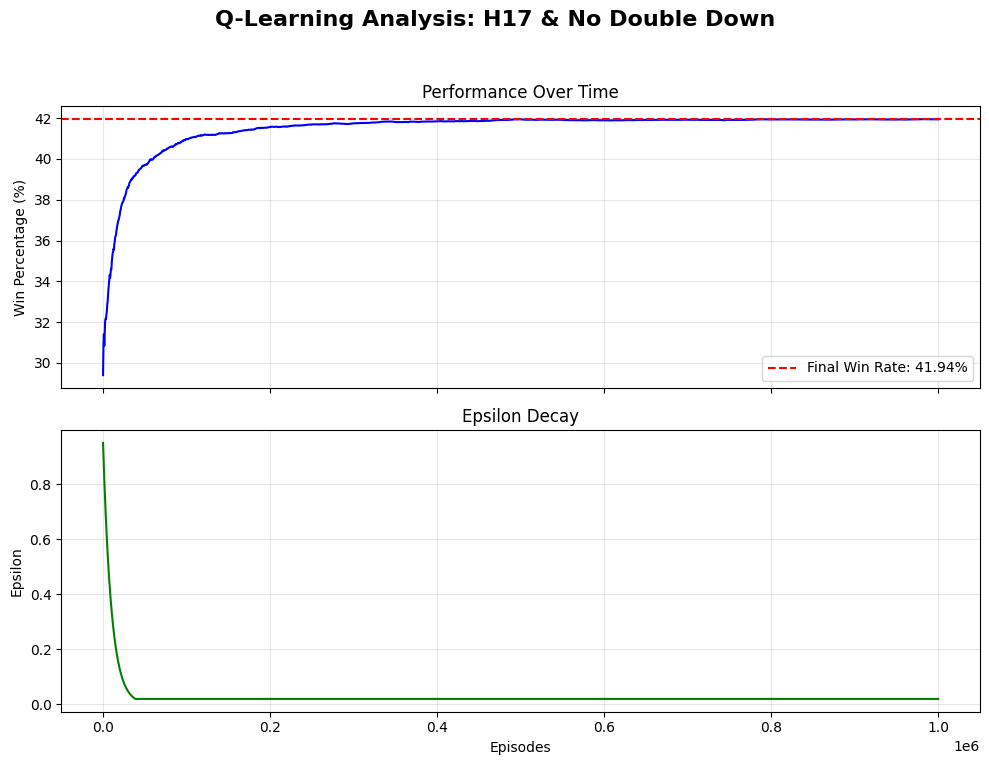

In [ ]:
def run_q_learning_simulation(rule_variation_name, env, num_episodes=1000000):
    """
    Runs a Q-Learning simulation on a Blackjack environment with specified rule variations.
    Tracks win rates and epsilon decay, and plots results.
    """

    # Print simulation header
    print("\n" + "="*70)
    print(f"Q-Learning Simulation: {rule_variation_name}")
    print("="*70)

    # ----------------------------------------
    # Hyperparameters & Initializations
    # ----------------------------------------
    LEARNING_RATE = 0.1          # Alpha: how quickly to update Q-values
    INITIAL_EPSILON = 1.0        # Start fully exploring
    EPSILON_DECAY = 0.9999       # Slow decay for exploration-exploitation trade-off
    MIN_EPSILON = 0.02           # Minimum epsilon to maintain some exploration
    GAMMA = 0.95                 # Discount factor: value of future rewards

    strategy = ThorpBasicStrategy()             # For tie-breaks when Q-values tie
    Q = defaultdict(lambda: defaultdict(float)) # Q-table: nested dict [state][action] = value
    epsilon = INITIAL_EPSILON

    # Counters for performance stats
    wins, losses, draws = 0, 0, 0

    # For plotting progress
    win_rates, episodes_list, epsilons = [], [], []

    # ----------------------------------------
    # Helper: Legal actions given state
    # ----------------------------------------
    def get_legal_actions(state):
        return [0, 1, 2] if state[3] else [0, 1]  # If can_double (4th state element), include double down

    # ----------------------------------------
    # Helper: Epsilon-Greedy Action Selection
    # ----------------------------------------
    def epsilon_greedy_action(state, Q_table, eps, strat):
        legal_actions = get_legal_actions(state)
        if not legal_actions:
            return 0  # Safeguard: should never happen

        # Explore
        if random.random() < eps:
            return random.choice(legal_actions)

        # Exploit: pick action with max Q-value
        q_vals = {action: Q_table[state][action] for action in legal_actions}
        max_q = max(q_vals.values())
        best_actions = [action for action, q in q_vals.items() if q == max_q]

        # If tie, use Thorp strategy for tie-break
        return best_actions[0] if len(best_actions) == 1 else strat.get_action(state)

    # ----------------------------------------
    # Main Q-Learning Loop
    # ----------------------------------------
    for episode in range(num_episodes):
        state = env.reset()  # Reset environment to new game
        done = False

        while not done:
            action = epsilon_greedy_action(state, Q, epsilon, strategy)
            next_state, reward, done = env.step(action)

            # Q-Learning update
            best_next_q = max([Q[next_state][a] for a in get_legal_actions(next_state)]) if not done else 0
            Q[state][action] += LEARNING_RATE * (reward + GAMMA * best_next_q - Q[state][action])

            state = next_state  # Move to next state

        # Track outcome
        if reward > 0:
            wins += 1
        elif reward < 0:
            losses += 1
        else:
            draws += 1

        # Decay epsilon
        epsilon = max(MIN_EPSILON, epsilon * EPSILON_DECAY)

        # Save stats every 500 episodes for plotting
        if (episode + 1) % 500 == 0:
            win_rates.append(wins / (episode + 1) * 100)
            episodes_list.append(episode + 1)
            epsilons.append(epsilon)

    # ----------------------------------------
    # Final results
    # ----------------------------------------
    total_games = wins + losses + draws
    win_p = (wins / total_games) * 100
    loss_p = (losses / total_games) * 100
    draw_p = (draws / total_games) * 100

    print("\nFINAL RESULTS:")
    print(f"Wins: {wins} ({win_p:.2f}%) | Losses: {losses} ({loss_p:.2f}%) | Draws: {draw_p:.2f}%)")

    # ----------------------------------------
    # Plot win rates and epsilon decay
    # ----------------------------------------
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 8), sharex=True)
    fig.suptitle(f'Q-Learning Analysis: {rule_variation_name}', fontsize=16, fontweight='bold')

    # Win rate plot
    ax1.plot(episodes_list, win_rates, 'b')
    ax1.axhline(y=win_p, color='r', linestyle='--', label=f'Final Win Rate: {win_p:.2f}%')
    ax1.set(ylabel='Win Percentage (%)', title='Performance Over Time')
    ax1.grid(True, alpha=0.3)
    ax1.legend()

    # Epsilon decay plot
    ax2.plot(episodes_list, epsilons, 'g')
    ax2.set(xlabel='Episodes', ylabel='Epsilon', title='Epsilon Decay')
    ax2.grid(True, alpha=0.3)

    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()


# --- Example usage: run Q-Learning for a custom Blackjack rule set ---
env_q_combined = BlackjackEnvWithVariations(dealer_hits_on_soft_17=True, allow_double_down=False)
run_q_learning_simulation("H17 & No Double Down", env_q_combined)


SARSA with rule variations (basic strategy)


SARSA Simulation: H17 & No Double Down

FINAL RESULTS:
Wins: 418512 (41.85%) | Losses: 493330 (49.33%) | Draws: 88158 (8.82%)


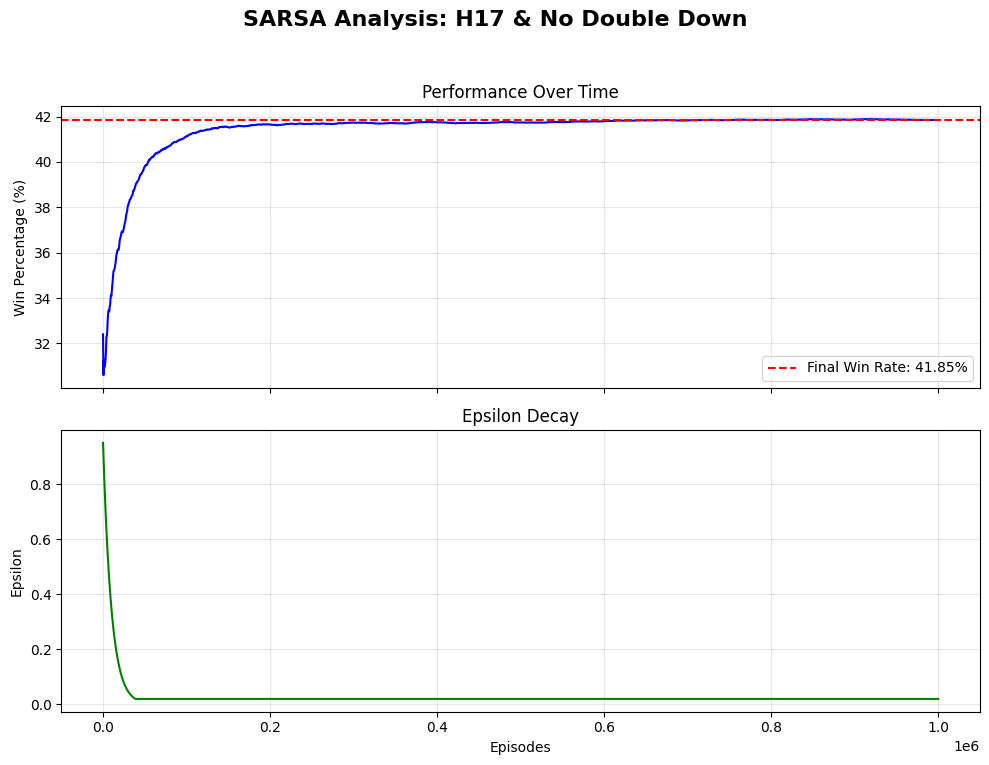

In [ ]:
def run_sarsa_simulation(rule_variation_name, env, num_episodes=1000000):
    """
    Runs a SARSA simulation on a Blackjack environment with specified rule variations.
    Tracks win rates and epsilon decay, and plots results.
    """

    # Print simulation header
    print("\n" + "="*70)
    print(f"SARSA Simulation: {rule_variation_name}")
    print("="*70)

    # ----------------------------------------
    # Hyperparameters & Initializations
    # ----------------------------------------
    LEARNING_RATE = 0.1           # Alpha: learning rate for SARSA updates
    INITIAL_EPSILON = 1.0         # Start fully exploring
    EPSILON_DECAY = 0.9999        # How fast exploration decreases
    MIN_EPSILON = 0.02            # Minimum exploration threshold
    GAMMA = 0.95                  # Discount factor for future rewards

    strategy = ThorpBasicStrategy()             # Basic strategy for resolving ties
    Q = defaultdict(lambda: defaultdict(float)) # Q-table: nested dict [state][action] -> value
    epsilon = INITIAL_EPSILON                   # Initialize epsilon

    # Track performance stats
    wins, losses, draws = 0, 0, 0

    # For plotting learning progress
    win_rates, episodes_list, epsilons = [], [], []

    # ----------------------------------------
    # Helper: Determine legal actions for state
    # ----------------------------------------
    def get_legal_actions(state):
        return [0, 1, 2] if state[3] else [0, 1]  # If can_double is True (state[3]), allow Double Down

    # ----------------------------------------
    # Helper: Epsilon-Greedy Policy
    # ----------------------------------------
    def epsilon_greedy_action(state, Q_table, eps, strat):
        legal_actions = get_legal_actions(state)
        if not legal_actions:
            return 0  # Safeguard: no legal actions shouldn't happen
        if random.random() < eps:
            return random.choice(legal_actions)  # Explore
        q_vals = {action: Q_table[state][action] for action in legal_actions}
        max_q = max(q_vals.values())
        best_actions = [action for action, q in q_vals.items() if q == max_q]
        return best_actions[0] if len(best_actions) == 1 else strat.get_action(state)  # Tie-break

    # ----------------------------------------
    # Main SARSA Loop
    # ----------------------------------------
    for episode in range(num_episodes):
        state = env.reset()                              # New game
        action = epsilon_greedy_action(state, Q, epsilon, strategy)  # Initial action
        done = False
        reward = 0

        while not done:
            next_state, reward, done = env.step(action)  # Take action, get result
            next_action = epsilon_greedy_action(next_state, Q, epsilon, strategy)  # Next action (on-policy!)
            target_q = Q[next_state][next_action] if not done else 0  # Next Q-value, or 0 if terminal
            Q[state][action] += LEARNING_RATE * (reward + GAMMA * target_q - Q[state][action])  # SARSA update
            state, action = next_state, next_action       # Move to next state-action pair

        # Update performance counters
        if reward > 0:
            wins += 1
        elif reward < 0:
            losses += 1
        else:
            draws += 1

        # Decay epsilon
        epsilon = max(MIN_EPSILON, epsilon * EPSILON_DECAY)

        # Save stats every 500 episodes
        if (episode + 1) % 500 == 0:
            win_rates.append(wins / (episode + 1) * 100)
            episodes_list.append(episode + 1)
            epsilons.append(epsilon)

    # ----------------------------------------
    # Print final stats
    # ----------------------------------------
    total_games = wins + losses + draws
    win_p = (wins / total_games) * 100
    loss_p = (losses / total_games) * 100
    draw_p = (draws / total_games) * 100

    print("\nFINAL RESULTS:")
    print(f"Wins: {wins} ({win_p:.2f}%) | Losses: {losses} ({loss_p:.2f}%) | Draws: {draws} ({draw_p:.2f}%)")

    # ----------------------------------------
    # Plot results: win rate & epsilon decay
    # ----------------------------------------
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 8), sharex=True)
    fig.suptitle(f'SARSA Analysis: {rule_variation_name}', fontsize=16, fontweight='bold')

    # Plot win rates
    ax1.plot(episodes_list, win_rates, 'b')
    ax1.axhline(y=win_p, color='r', linestyle='--', label=f'Final Win Rate: {win_p:.2f}%')
    ax1.set(ylabel='Win Percentage (%)', title='Performance Over Time')
    ax1.grid(True, alpha=0.3)
    ax1.legend()

    # Plot epsilon decay
    ax2.plot(episodes_list, epsilons, 'g')
    ax2.set(xlabel='Episodes', ylabel='Epsilon', title='Epsilon Decay')
    ax2.grid(True, alpha=0.3)

    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()


# --- Example usage: run SARSA for a custom Blackjack rule variation ---
env_s_combined = BlackjackEnvWithVariations(dealer_hits_on_soft_17=True, allow_double_down=False)
run_sarsa_simulation("H17 & No Double Down", env_s_combined)


Comparison for all three Baseline,Qlearning,SARSA

PERFORMANCE COMPARISON UNDER STANDARD RULES
  Running Baseline for 100000 episodes...
  Baseline Final Win Rate: 29.65%
  Running Q-Learning for 100000 episodes...
  Q-Learning Final Win Rate: 40.59%
  Running SARSA for 100000 episodes...
  SARSA Final Win Rate: 40.55%


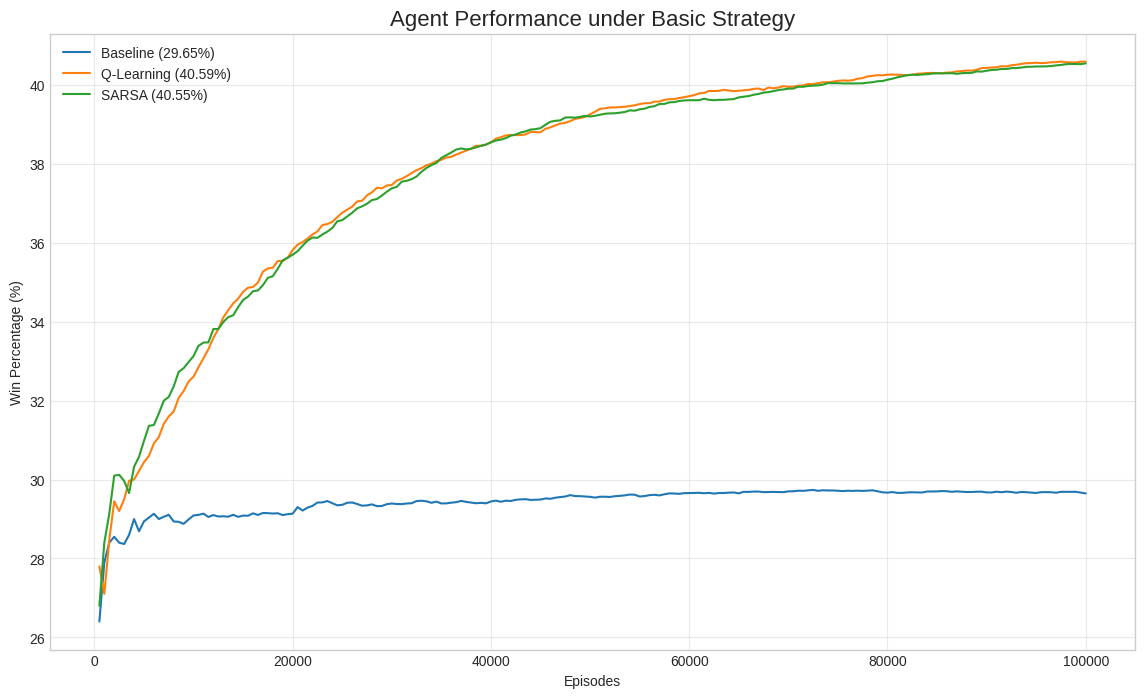


PERFORMANCE COMPARISON UNDER MODIFIED RULES
  Running Q-Learning for 100000 episodes...
  Q-Learning Final Win Rate: 40.78%
  Running SARSA for 100000 episodes...
  SARSA Final Win Rate: 40.80%


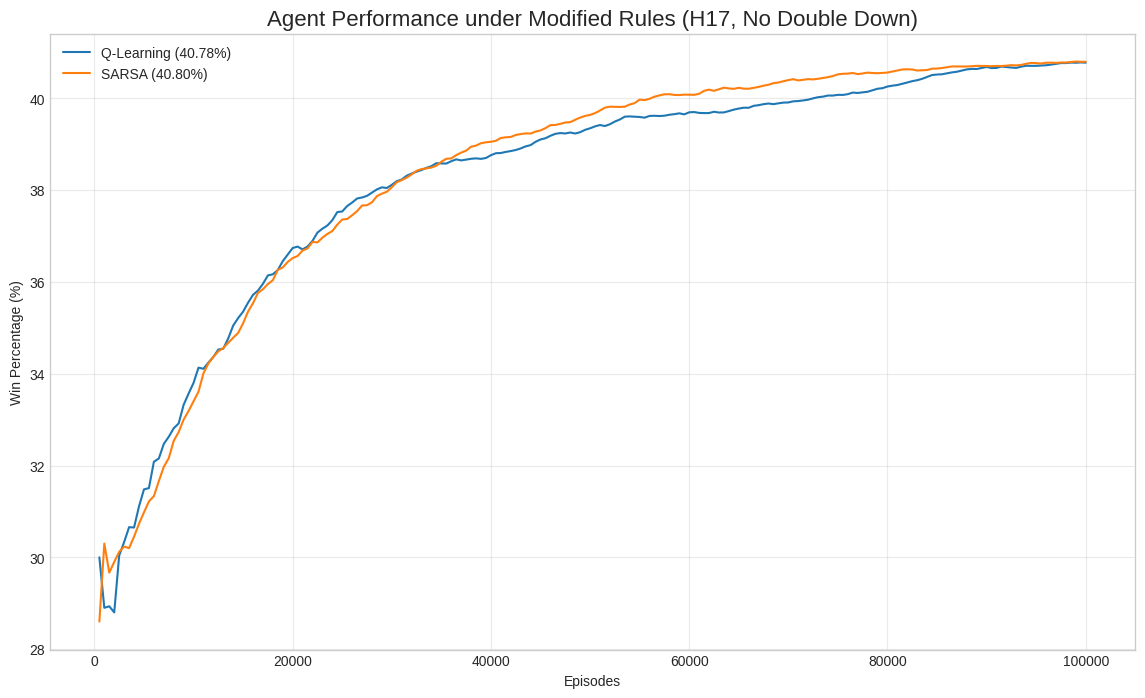

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import random
from collections import defaultdict
from typing import Tuple, List, Dict, Any

## ------------------------------------------------------------------
## 1. ENVIRONMENT AND STRATEGY DEFINITIONS
## ------------------------------------------------------------------

class BlackjackEnv:
    """Standard Blackjack Environment where the dealer stands on all 17s."""
    def __init__(self):
        self.reset()

    def reset(self) -> Tuple[int, int, bool, bool]:
        self.deck = [2, 3, 4, 5, 6, 7, 8, 9, 10, 10, 10, 10, 11] * 4
        random.shuffle(self.deck)
        self.player_hand = [self.deck.pop(), self.deck.pop()]
        self.dealer_hand = [self.deck.pop(), self.deck.pop()]
        return self._get_state()

    def _get_hand_value(self, hand: List[int]) -> int:
        value = sum(hand)
        num_aces = hand.count(11)
        while value > 21 and num_aces > 0:
            value -= 10
            num_aces -= 1
        return value

    def _has_soft_ace(self, hand: List[int]) -> bool:
        return 11 in hand and self._get_hand_value(hand) <= 21

    def _get_state(self) -> Tuple[int, int, bool, bool]:
        player_value = self._get_hand_value(self.player_hand)
        dealer_showing = self.dealer_hand[0]
        if dealer_showing == 11: dealer_showing = 1
        can_double = len(self.player_hand) == 2
        return (player_value, dealer_showing, self._has_soft_ace(self.player_hand), can_double)

    def step(self, action: int) -> Tuple[Any, int, bool]:
        reward_multiplier = 1
        if action == 2:
            if len(self.player_hand) != 2: action = 1
            else: reward_multiplier = 2

        if action in [1, 2]:
            self.player_hand.append(self.deck.pop())
            if self._get_hand_value(self.player_hand) > 21:
                return self._get_state(), -1 * reward_multiplier, True
            if action == 2:
                return self._dealer_turn(reward_multiplier)
            return self._get_state(), 0, False
        else: # Stand
            return self._dealer_turn(reward_multiplier)

    def _dealer_turn(self, reward_multiplier: int) -> Tuple[Any, int, bool]:
        while self._get_hand_value(self.dealer_hand) < 17:
            self.dealer_hand.append(self.deck.pop())
        player_value = self._get_hand_value(self.player_hand)
        dealer_value = self._get_hand_value(self.dealer_hand)
        reward = 0
        if dealer_value > 21 or player_value > dealer_value: reward = 1
        elif player_value < dealer_value: reward = -1
        return self._get_state(), reward * reward_multiplier, True

class BlackjackEnvWithVariations(BlackjackEnv):
    """Blackjack Environment with configurable rule variations."""
    def __init__(self, dealer_hits_on_soft_17: bool, allow_double_down: bool):
        self.dealer_hits_on_soft_17 = dealer_hits_on_soft_17
        self.allow_double_down = allow_double_down
        super().__init__()

    def _get_state(self) -> Tuple[int, int, bool, bool]:
        player_value, dealer_showing, is_soft, _ = super()._get_state()
        can_double = self.allow_double_down and len(self.player_hand) == 2
        return (player_value, dealer_showing, is_soft, can_double)

    def step(self, action: int) -> Tuple[Any, int, bool]:
        if action == 2 and not self.allow_double_down:
            action = 1
        return super().step(action)

    def _dealer_turn(self, reward_multiplier: int) -> Tuple[Any, int, bool]:
        while True:
            dealer_value = self._get_hand_value(self.dealer_hand)
            is_soft = self._has_soft_ace(self.dealer_hand)
            if dealer_value > 17: break
            if dealer_value == 17 and not (is_soft and self.dealer_hits_on_soft_17): break
            self.dealer_hand.append(self.deck.pop())
        return super()._dealer_turn(reward_multiplier)

class ThorpBasicStrategy:
    """Implements Thorp's Basic Strategy for tie-breaking."""
    def __init__(self):
        # CORRECTED: Dictionaries are defined once in __init__ and cleaned of invalid characters.
        self.hard_strategy = {
            17: {d: 0 for d in range(1, 11)},
            16: {d: 0 if d <= 6 else 1 for d in range(1, 11)},
            15: {d: 0 if d <= 6 else 1 for d in range(1, 11)},
            14: {d: 0 if d <= 6 else 1 for d in range(1, 11)},
            13: {d: 0 if d <= 6 else 1 for d in range(1, 11)},
            12: {d: 1 if d <= 3 or d >= 7 else 0 for d in range(1, 11)},
            11: {d: 2 for d in range(1, 11)},
            10: {d: 2 if d <= 9 else 1 for d in range(1, 11)},
            9:  {d: 2 if 3 <= d <= 6 else 1 for d in range(1, 11)},
        }
        self.soft_strategy = {
            19: {d: 0 for d in range(1, 11)},
            18: {d: 2 if 2 <= d <= 6 else (0 if d <= 8 else 1) for d in range(1, 11)},
            17: {d: 2 if 3 <= d <= 6 else 1 for d in range(1, 11)},
            16: {d: 2 if 4 <= d <= 6 else 1 for d in range(1, 11)},
            15: {d: 2 if 4 <= d <= 6 else 1 for d in range(1, 11)},
            14: {d: 2 if 5 <= d <= 6 else 1 for d in range(1, 11)},
            13: {d: 2 if 5 <= d <= 6 else 1 for d in range(1, 11)},
        }

    def get_action(self, state: Tuple[int, int, bool, bool]) -> int:
        player_val, dealer_card, is_soft, can_double = state
        if player_val >= 20 and not is_soft: return 0
        if player_val <= 8: return 1

        table = self.soft_strategy if is_soft else self.hard_strategy
        action = table.get(player_val, {}).get(dealer_card, 1)

        if action == 2 and not can_double: return 1
        return action

def get_legal_actions(state: Tuple[int, int, bool, bool]) -> List[int]:
    return [0, 1, 2] if state[3] else [0, 1]

## ------------------------------------------------------------------
## 2. AGENT-SPECIFIC SIMULATION FUNCTIONS
## ------------------------------------------------------------------

def run_baseline_simulation(env, num_episodes, params):
    print(f"  Running Baseline for {num_episodes} episodes...")
    strategy = ThorpBasicStrategy()
    wins, win_rates, episodes_list = 0, [], []

    for episode in range(num_episodes):
        state = env.reset()
        done = False
        final_reward = 0
        while not done:
            if random.random() < params['epsilon']:
                action = random.choice(get_legal_actions(state))
            else:
                action = strategy.get_action(state)
            state, reward, done = env.step(action)
            if done: final_reward = reward
        if final_reward > 0: wins += 1
        if (episode + 1) % 500 == 0:
            win_rates.append(wins / (episode + 1) * 100)
            episodes_list.append(episode + 1)

    final_win_rate = (wins / num_episodes) * 100
    print(f"  Baseline Final Win Rate: {final_win_rate:.2f}%")
    return {'episodes': episodes_list, 'win_rates': win_rates, 'label': f'Baseline ({final_win_rate:.2f}%)'}

def run_q_learning_simulation(env, num_episodes, params):
    print(f"  Running Q-Learning for {num_episodes} episodes...")
    Q, strategy = defaultdict(lambda: defaultdict(float)), ThorpBasicStrategy()
    epsilon = params['initial_epsilon']
    wins, win_rates, episodes_list = 0, [], []

    def epsilon_greedy_action(state, Q_table, eps):
        legal_actions = get_legal_actions(state)
        if random.random() < eps or not any(Q_table[state].values()):
            return random.choice(legal_actions)
        q_vals = {a: Q_table[state][a] for a in legal_actions}
        max_q = max(q_vals.values())
        best_actions = [a for a, q in q_vals.items() if q == max_q]
        if len(best_actions) > 1: return strategy.get_action(state)
        return best_actions[0]

    for episode in range(num_episodes):
        state = env.reset()
        done = False
        final_reward = 0
        while not done:
            action = epsilon_greedy_action(state, Q, epsilon)
            next_state, reward, done = env.step(action)
            best_next_q = max([Q[next_state][a] for a in get_legal_actions(next_state)], default=0) if not done else 0
            Q[state][action] += params['alpha'] * (reward + params['gamma'] * best_next_q - Q[state][action])
            state = next_state
            if done: final_reward = reward
        if final_reward > 0: wins += 1
        epsilon = max(params['min_epsilon'], epsilon * params['epsilon_decay'])
        if (episode + 1) % 500 == 0:
            win_rates.append(wins / (episode + 1) * 100)
            episodes_list.append(episode + 1)

    final_win_rate = (wins / num_episodes) * 100
    print(f"  Q-Learning Final Win Rate: {final_win_rate:.2f}%")
    return {'episodes': episodes_list, 'win_rates': win_rates, 'label': f'Q-Learning ({final_win_rate:.2f}%)'}

def run_sarsa_simulation(env, num_episodes, params):
    """This function uses the original, unchanged SARSA logic."""
    print(f"  Running SARSA for {num_episodes} episodes...")
    Q, strategy = defaultdict(lambda: defaultdict(float)), ThorpBasicStrategy()
    epsilon = params['initial_epsilon']
    wins, win_rates, episodes_list = 0, [], []

    def epsilon_greedy_action(state, Q_table, eps):
        legal_actions = get_legal_actions(state)
        if random.random() < eps or not any(Q_table[state].values()):
            return random.choice(legal_actions)
        q_vals = {a: Q_table[state][a] for a in legal_actions}
        max_q = max(q_vals.values())
        best_actions = [a for a, q in q_vals.items() if q == max_q]
        if len(best_actions) > 1: return strategy.get_action(state)
        return best_actions[0]

    for episode in range(num_episodes):
        state = env.reset()
        action = epsilon_greedy_action(state, Q, epsilon)
        done = False
        final_reward = 0
        while not done:
            next_state, reward, done = env.step(action)
            next_action = epsilon_greedy_action(next_state, Q, epsilon) if not done else 0
            target_q = Q[next_state][next_action] if not done else 0
            Q[state][action] += params['alpha'] * (reward + params['gamma'] * target_q - Q[state][action])
            state, action = next_state, next_action
            if done: final_reward = reward
        if final_reward > 0: wins += 1
        epsilon = max(params['min_epsilon'], epsilon * params['epsilon_decay'])
        if (episode + 1) % 500 == 0:
            win_rates.append(wins / (episode + 1) * 100)
            episodes_list.append(episode + 1)

    final_win_rate = (wins / num_episodes) * 100
    print(f"  SARSA Final Win Rate: {final_win_rate:.2f}%")
    return {'episodes': episodes_list, 'win_rates': win_rates, 'label': f'SARSA ({final_win_rate:.2f}%)'}

def plot_comparison(results: List[Dict], title: str):
    plt.figure(figsize=(14, 8))
    for result in results:
        plt.plot(result['episodes'], result['win_rates'], label=result['label'])
    plt.title(title, fontsize=16)
    plt.xlabel('Episodes'); plt.ylabel('Win Percentage (%)')
    plt.legend(); plt.grid(True, alpha=0.4)
    plt.show()

## ------------------------------------------------------------------
## 3. MAIN EXECUTION
## ------------------------------------------------------------------
LEARNING_PARAMS = {'alpha': 0.1, 'gamma': 0.95, 'initial_epsilon': 1.0, 'epsilon_decay': 0.9999, 'min_epsilon': 0.02}
BASELINE_PARAMS = {'epsilon': 0.1}
NUM_EPISODES = 100_000

# --- COMPARISON 1: STANDARD RULES ---
print("="*50); print("PERFORMANCE COMPARISON UNDER STANDARD RULES"); print("="*50)
env_standard = BlackjackEnv()
results_standard = [
    run_baseline_simulation(env_standard, NUM_EPISODES, BASELINE_PARAMS),
    run_q_learning_simulation(env_standard, NUM_EPISODES, LEARNING_PARAMS),
    run_sarsa_simulation(env_standard, NUM_EPISODES, LEARNING_PARAMS)
]
plot_comparison(results_standard, 'Agent Performance under Basic Strategy')

# --- COMPARISON 2: MODIFIED RULES (H17 & NO DOUBLE DOWN) ---
print("\n" + "="*50); print("PERFORMANCE COMPARISON UNDER MODIFIED RULES"); print("="*50)
env_modified = BlackjackEnvWithVariations(dealer_hits_on_soft_17=True, allow_double_down=False)
results_modified = [
    run_q_learning_simulation(env_modified, NUM_EPISODES, LEARNING_PARAMS),
    run_sarsa_simulation(env_modified, NUM_EPISODES, LEARNING_PARAMS)
]
plot_comparison(results_modified, 'Agent Performance under Modified Rules (H17, No Double Down)')

#Complete Point-Count System enironment

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import random
from collections import defaultdict
from typing import Tuple, List

class BlackjackEnvWithCounting:
    """
    Blackjack Environment that implements the Hi-Lo point-count system.
    The state is expanded to include the 'True Count'.
    This environment uses standard rules: Dealer stands on all 17s, Double Down is allowed.
    """
    def __init__(self, num_decks=4):
        self.num_decks = num_decks
        # Hi-Lo Point Values
        self.card_points = {
            2: 1, 3: 1, 4: 1, 5: 1, 6: 1,
            7: 0, 8: 0, 9: 0,
            10: -1, 11: -1
        }
        self.reset()

    def reset(self):
        """ Resets the game: new deck, reset count, and deal initial hands. """
        self.deck = [2, 3, 4, 5, 6, 7, 8, 9, 10, 10, 10, 10, 11] * self.num_decks
        random.shuffle(self.deck)
        self.running_count = 0

        self.player_hand = [self._deal_card(), self._deal_card()]
        self.dealer_hand = [self._deal_card(), self._deal_card()]

        return self._get_state()

    def _deal_card(self):
        """ Deals a single card and updates the running count. """
        card = self.deck.pop()
        self.running_count += self.card_points[card]
        return card

    def _get_true_count(self):
        """ Calculates and discretizes the true count. """
        if not self.deck: return self.running_count
        decks_remaining = len(self.deck) / 52.0
        return int(round(self.running_count / decks_remaining))

    def _get_hand_value(self, hand: List[int]) -> int:
        value = sum(hand)
        num_aces = hand.count(11)
        while value > 21 and num_aces > 0:
            value -= 10
            num_aces -= 1
        return value

    def _has_soft_ace(self, hand: List[int]) -> bool:
        return 11 in hand and self._get_hand_value(hand) <= 21

    def _get_state(self) -> Tuple[int, int, bool, bool, int]:
        """ Returns the complete state of the game including the true count. """
        player_value = self._get_hand_value(self.player_hand)
        dealer_showing = self.dealer_hand[0]
        if dealer_showing == 11: dealer_showing = 1 # Use 1 for Ace for consistency in state
        can_double = len(self.player_hand) == 2
        true_count = self._get_true_count()
        return (player_value, dealer_showing, self._has_soft_ace(self.player_hand), can_double, true_count)

    def step(self, action: int) -> Tuple[Tuple, int, bool]:
        reward_multiplier = 1
        if action == 2: # Double Down
            if len(self.player_hand) != 2: action = 1 # Illegal move, treat as Hit
            else: reward_multiplier = 2

        if action == 1 or action == 2: # Hit or legal Double Down
            self.player_hand.append(self._deal_card())
            if self._get_hand_value(self.player_hand) > 21:
                return self._get_state(), -1 * reward_multiplier, True
            if action == 2: # Game ends after doubling down
                return self._dealer_turn(reward_multiplier)
            return self._get_state(), 0, False
        else: # Stand
            return self._dealer_turn(reward_multiplier)

    def _dealer_turn(self, reward_multiplier):
        # Standard Rule: Dealer stands on all 17s.
        while self._get_hand_value(self.dealer_hand) < 17:
            self.dealer_hand.append(self._deal_card())

        player_value = self._get_hand_value(self.player_hand)
        dealer_value = self._get_hand_value(self.dealer_hand)
        reward = 0
        if dealer_value > 21 or player_value > dealer_value: reward = 1
        elif player_value < dealer_value: reward = -1
        return self._get_state(), reward * reward_multiplier, True

# Basic strategy is used as a fallback for tie-breaking in the agent's policy
class ThorpBasicStrategy:
    def __init__(self):
        self.hard_strategy={11:{d:2 for d in range(1,11)},10:{d:2 if d<=9 else 1 for d in range(1,11)},9:{d:2 if 3<=d<=6 else 1 for d in range(1,11)},17:{d:0 for d in range(1,11)},16:{d:0 if d<=6 else 1 for d in range(1,11)},15:{d:0 if d<=6 else 1 for d in range(1,11)},14:{d:0 if d<=6 else 1 for d in range(1,11)},13:{d:0 if d<=6 else 1 for d in range(1,11)},12:{d:1 if d<=3 or d>=7 else 0 for d in range(1,11)}}
        self.soft_strategy={19:{d:0 for d in range(1,11)},18:{d:2 if 2<=d<=6 else(0 if d<=8 else 1)for d in range(1,11)},17:{d:2 if 3<=d<=6 else 1 for d in range(1,11)},16:{d:2 if 4<=d<=6 else 1 for d in range(1,11)},15:{d:2 if 4<=d<=6 else 1 for d in range(1,11)},14:{d:2 if 5<=d<=6 else 1 for d in range(1,11)},13:{d:2 if 5<=d<=6 else 1 for d in range(1,11)}}
    def get_action(self,state):
        # The basic strategy does not use the true_count, which is the point of the learning agent
        player_val,dealer_card,is_soft,can_double,true_count = state
        if player_val>=20 and not is_soft:return 0
        if player_val<=8:return 1
        table=self.soft_strategy if is_soft else self.hard_strategy
        action=table.get(player_val,{}).get(dealer_card,1)
        if action==2 and not can_double:return 1
        return action

Q-learning with Complete Point-Count System


Q-Learning with Complete Point-Count System (Standard Rules)

FINAL RESULTS:
Wins: 435606 (43.56%) | Losses: 472755 (47.28%) | Draws: 9.16%)


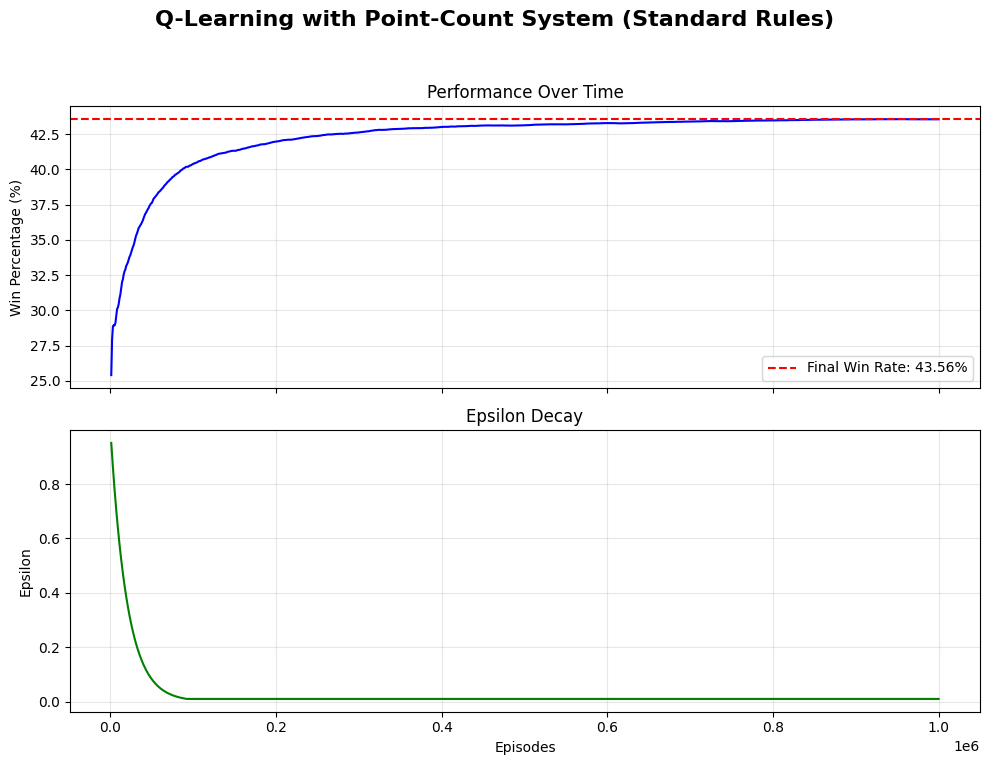

In [ ]:
def run_q_learning_with_counting(num_episodes=1000000):
    """
    Run a Q-Learning simulation for Blackjack with a complete point-count system.
    Uses standard rules and tracks performance over time.
    """

    # Print header for clarity
    print("\n" + "="*70)
    print("Q-Learning with Complete Point-Count System (Standard Rules)")
    print("="*70)

    # -----------------------------------------------------------
    # Hyperparameters & Environment Setup
    # -----------------------------------------------------------
    env = BlackjackEnvWithCounting()  # Custom Blackjack environment with a card counting state feature

    LEARNING_RATE = 0.1      # Alpha: How much to update Q-values by each step
    INITIAL_EPSILON = 1.0    # Start fully exploring actions
    EPSILON_DECAY = 0.99995  # Decay factor per episode to reduce exploration gradually
    MIN_EPSILON = 0.01       # Minimum exploration threshold
    GAMMA = 0.95             # Discount factor for future rewards

    strategy = ThorpBasicStrategy()  # Tie-breaker strategy: fallback to basic strategy when needed

    # Q-Table: maps states -> actions -> estimated Q-values
    Q = defaultdict(lambda: defaultdict(float))

    epsilon = INITIAL_EPSILON  # Initialize epsilon

    # Track win/loss/draw stats
    wins, losses, draws = 0, 0, 0

    # Lists to save win rates and epsilon values for plotting
    win_rates, episodes_list, epsilons = [], [], []

    # -----------------------------------------------------------
    # Helper: Determine legal actions for a given state
    # -----------------------------------------------------------
    def get_legal_actions(state):
        # If can_double (state[3] is True), allow actions: [0, 1, 2] (Hit, Stand, Double)
        # Else, only [0, 1] (Hit, Stand)
        return [0, 1, 2] if state[3] else [0, 1]

    # -----------------------------------------------------------
    # Helper: Epsilon-Greedy Action Selector
    # -----------------------------------------------------------
    def epsilon_greedy_action(state, Q_table, eps, strat):
        legal_actions = get_legal_actions(state)

        # Explore randomly with probability epsilon
        if random.random() < eps:
            return random.choice(legal_actions)

        # Otherwise, exploit: choose action with max Q-value
        q_vals = {action: Q_table[state][action] for action in legal_actions}
        max_q = max(q_vals.values())

        # Handle ties: multiple actions with same max Q
        best_actions = [action for action, q in q_vals.items() if q == max_q]

        # If unique, return it; otherwise use fallback strategy
        return best_actions[0] if len(best_actions) == 1 else strat.get_action(state)

    # -----------------------------------------------------------
    # Main Training Loop
    # -----------------------------------------------------------
    for episode in range(num_episodes):
        state = env.reset()    # Start a new game
        done = False           # Track if game is finished

        while not done:
            # Choose action with epsilon-greedy policy
            action = epsilon_greedy_action(state, Q, epsilon, strategy)

            # Take action, observe next state and reward
            next_state, reward, done = env.step(action)

            # Estimate optimal next Q: max over next legal actions
            if not done:
                best_next_q = max([Q[next_state][a] for a in get_legal_actions(next_state)])
            else:
                best_next_q = 0

            # Q-Learning update rule (off-policy TD control)
            Q[state][action] += LEARNING_RATE * (reward + GAMMA * best_next_q - Q[state][action])

            # Move to next state
            state = next_state

        # Update win/loss/draw counters based on final reward
        if reward > 0:
            wins += 1
        elif reward < 0:
            losses += 1
        else:
            draws += 1

        # Decay epsilon: ensure it doesn't drop below minimum
        epsilon = max(MIN_EPSILON, epsilon * EPSILON_DECAY)

        # Every 1000 episodes, log stats for plotting
        if (episode + 1) % 1000 == 0:
            win_rate = wins / (episode + 1) * 100
            win_rates.append(win_rate)
            episodes_list.append(episode + 1)
            epsilons.append(epsilon)

    # -----------------------------------------------------------
    # Print final statistics
    # -----------------------------------------------------------
    total_games = wins + losses + draws
    win_p = (wins / total_games) * 100
    loss_p = (losses / total_games) * 100
    draw_p = (draws / total_games) * 100

    print("\nFINAL RESULTS:")
    print(f"Wins: {wins} ({win_p:.2f}%) | Losses: {losses} ({loss_p:.2f}%) | Draws: {draw_p:.2f}%)")

    # -----------------------------------------------------------
    # Plot final win percentage and epsilon decay
    # -----------------------------------------------------------
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 8), sharex=True)
    fig.suptitle('Q-Learning with Point-Count System (Standard Rules)', fontsize=16, fontweight='bold')

    # Plot win rate over episodes
    ax1.plot(episodes_list, win_rates, color='b')
    ax1.axhline(y=win_p, color='r', linestyle='--', label=f'Final Win Rate: {win_p:.2f}%')
    ax1.set(ylabel='Win Percentage (%)', title='Performance Over Time')
    ax1.grid(True, alpha=0.3)
    ax1.legend()

    # Plot epsilon decay over episodes
    ax2.plot(episodes_list, epsilons, color='g')
    ax2.set(xlabel='Episodes', ylabel='Epsilon', title='Epsilon Decay')
    ax2.grid(True, alpha=0.3)

    # Adjust layout and display plot
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()


# -----------------------------------------------------------
# Run the simulation with the default number of episodes
# -----------------------------------------------------------
run_q_learning_with_counting()


SARSA with Complete Point-Count System


SARSA with Complete Point-Count System (Standard Rules)

FINAL RESULTS:
Wins: 437508 (43.75%) | Losses: 471943 (47.19%) | Draws: 9.05%)


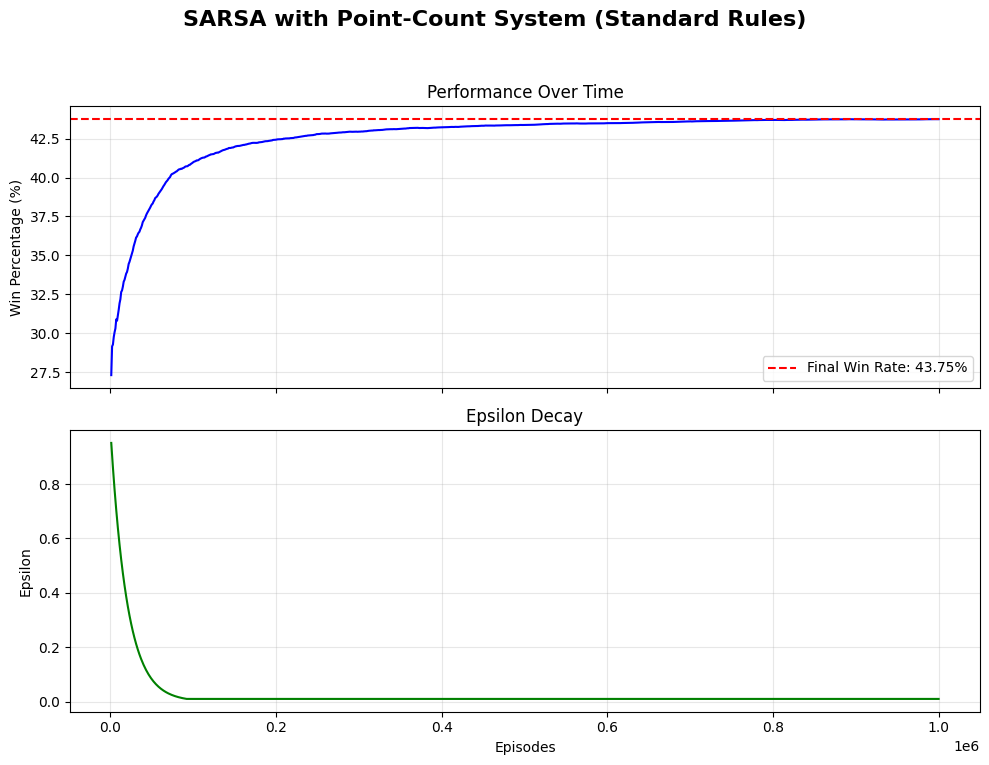

In [ ]:
def run_sarsa_with_counting(num_episodes=1000000):
    """
    Run a SARSA simulation for Blackjack with a complete point-count system.
    Uses standard rules and tracks performance over time.
    """

    # -----------------------------------------------------------
    # Print header for clarity
    # -----------------------------------------------------------
    print("\n" + "="*70)
    print("SARSA with Complete Point-Count System (Standard Rules)")
    print("="*70)

    # -----------------------------------------------------------
    # Hyperparameters & Environment Setup
    # -----------------------------------------------------------
    env = BlackjackEnvWithCounting()  # Blackjack environment including card counting info

    LEARNING_RATE = 0.1      # Alpha: step size for Q-value updates
    INITIAL_EPSILON = 1.0    # Start with full exploration
    EPSILON_DECAY = 0.99995  # Decay factor to reduce exploration gradually
    MIN_EPSILON = 0.01       # Floor for epsilon (minimum exploration)
    GAMMA = 0.95             # Discount factor for future rewards

    strategy = ThorpBasicStrategy()  # Fallback strategy for tie-breaking

    # Q-Table: maps states to actions and their Q-values
    Q = defaultdict(lambda: defaultdict(float))

    epsilon = INITIAL_EPSILON  # Initialize epsilon

    # Stats counters
    wins, losses, draws = 0, 0, 0

    # For plotting
    win_rates, episodes_list, epsilons = [], [], []

    # -----------------------------------------------------------
    # Helper: Determine legal actions for current state
    # -----------------------------------------------------------
    def get_legal_actions(state):
        # If doubling is allowed (state[3] == True), include it
        return [0, 1, 2] if state[3] else [0, 1]

    # -----------------------------------------------------------
    # Helper: Epsilon-Greedy policy for SARSA
    # -----------------------------------------------------------
    def epsilon_greedy_action(state, Q_table, eps, strat):
        legal_actions = get_legal_actions(state)

        # Explore randomly with probability epsilon
        if random.random() < eps:
            return random.choice(legal_actions)

        # Otherwise pick best action by Q-value
        q_vals = {action: Q_table[state][action] for action in legal_actions}
        max_q = max(q_vals.values())
        best_actions = [action for action, q in q_vals.items() if q == max_q]

        # If multiple best, fallback to strategy
        return best_actions[0] if len(best_actions) == 1 else strat.get_action(state)

    # -----------------------------------------------------------
    # Main SARSA Training Loop
    # -----------------------------------------------------------
    for episode in range(num_episodes):
        state = env.reset()  # Start new game
        action = epsilon_greedy_action(state, Q, epsilon, strategy)  # Choose initial action
        done = False
        reward = 0

        while not done:
            # Take action -> observe next state, reward
            next_state, reward, done = env.step(action)

            # Choose next action (on-policy!)
            next_action = epsilon_greedy_action(next_state, Q, epsilon, strategy)

            # Compute TD target for SARSA (on-policy: Q[next_state][next_action])
            target_q = Q[next_state][next_action] if not done else 0

            # SARSA update rule
            Q[state][action] += LEARNING_RATE * (reward + GAMMA * target_q - Q[state][action])

            # Move to next state-action pair
            state, action = next_state, next_action

        # Update results counters
        if reward > 0:
            wins += 1
        elif reward < 0:
            losses += 1
        else:
            draws += 1

        # Decay exploration rate, respecting floor
        epsilon = max(MIN_EPSILON, epsilon * EPSILON_DECAY)

        # Log every 1000 episodes
        if (episode + 1) % 1000 == 0:
            win_rate = wins / (episode + 1) * 100
            win_rates.append(win_rate)
            episodes_list.append(episode + 1)
            epsilons.append(epsilon)

    # -----------------------------------------------------------
    # Final Results & Plotting
    # -----------------------------------------------------------
    total_games = wins + losses + draws
    win_p = (wins / total_games) * 100
    loss_p = (losses / total_games) * 100
    draw_p = (draws / total_games) * 100

    print("\nFINAL RESULTS:")
    print(f"Wins: {wins} ({win_p:.2f}%) | Losses: {losses} ({loss_p:.2f}%) | Draws: {draw_p:.2f}%)")

    # Plot win rate and epsilon decay
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 8), sharex=True)
    fig.suptitle('SARSA with Point-Count System (Standard Rules)', fontsize=16, fontweight='bold')

    # Win rate over time
    ax1.plot(episodes_list, win_rates, color='b')
    ax1.axhline(y=win_p, color='r', linestyle='--', label=f'Final Win Rate: {win_p:.2f}%')
    ax1.set(ylabel='Win Percentage (%)', title='Performance Over Time')
    ax1.grid(True, alpha=0.3)
    ax1.legend()

    # Epsilon decay curve
    ax2.plot(episodes_list, epsilons, color='g')
    ax2.set(xlabel='Episodes', ylabel='Epsilon', title='Epsilon Decay')
    ax2.grid(True, alpha=0.3)

    # Final layout and show plot
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()

# -----------------------------------------------------------
# Run SARSA with counting enabled
# -----------------------------------------------------------
run_sarsa_with_counting()


Complete Point-Count System enironment with rule Varitaions

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import random
from collections import defaultdict
from typing import Tuple, List

class BlackjackEnvAdvanced:
    """
    An advanced Blackjack Environment that incorporates:
    1. Hi-Lo point-count system.
    2. Configurable rule variations (H17, No Double Down).
    """
    def __init__(self, num_decks=4, dealer_hits_on_soft_17=False, allow_double_down=True):
        self.num_decks = num_decks
        self.dealer_hits_on_soft_17 = dealer_hits_on_soft_17
        self.allow_double_down = allow_double_down
        self.card_points = {2: 1, 3: 1, 4: 1, 5: 1, 6: 1, 7: 0, 8: 0, 9: 0, 10: -1, 11: -1}
        self.reset()

    def reset(self):
        self.deck = [2, 3, 4, 5, 6, 7, 8, 9, 10, 10, 10, 10, 11] * self.num_decks
        random.shuffle(self.deck)
        self.running_count = 0
        self.player_hand = [self._deal_card(), self._deal_card()]
        self.dealer_hand = [self._deal_card(), self._deal_card()]
        return self._get_state()

    def _deal_card(self):
        card = self.deck.pop()
        self.running_count += self.card_points[card]
        return card

    def _get_true_count(self):
        if not self.deck: return self.running_count
        decks_remaining = len(self.deck) / 52.0
        return int(round(self.running_count / decks_remaining))

    def _get_hand_value(self, hand):
        value = sum(hand)
        num_aces = hand.count(11)
        while value > 21 and num_aces > 0:
            value -= 10
            num_aces -= 1
        return value

    def _has_soft_ace(self, hand: List[int]) -> bool:
        return 11 in hand and self._get_hand_value(hand) <= 21

    def _get_state(self):
        player_value = self._get_hand_value(self.player_hand)
        dealer_showing = self.dealer_hand[0]
        if dealer_showing == 11: dealer_showing = 1
        can_double = self.allow_double_down and len(self.player_hand) == 2
        true_count = self._get_true_count()
        return (player_value, dealer_showing, self._has_soft_ace(self.player_hand), can_double, true_count)

    def step(self, action):
        reward_multiplier = 1
        if action == 2:
            if not (self.allow_double_down and len(self.player_hand) == 2):
                action = 1
            else:
                reward_multiplier = 2

        if action == 1 or action == 2:
            self.player_hand.append(self._deal_card())
            if self._get_hand_value(self.player_hand) > 21:
                return self._get_state(), -1 * reward_multiplier, True
            if action == 2:
                return self._dealer_turn(reward_multiplier)
            return self._get_state(), 0, False
        else:
            return self._dealer_turn(reward_multiplier)

    def _dealer_turn(self, reward_multiplier):
        while True:
            dealer_value = self._get_hand_value(self.dealer_hand)
            if dealer_value > 17: break
            if dealer_value < 17:
                self.dealer_hand.append(self._deal_card())
                continue
            # Logic for value == 17
            if not self.dealer_hits_on_soft_17 or not self._has_soft_ace(self.dealer_hand):
                break
            self.dealer_hand.append(self._deal_card()) # Hit on soft 17

        player_value = self._get_hand_value(self.player_hand)
        dealer_value = self._get_hand_value(self.dealer_hand)
        reward = 0
        if dealer_value > 21 or player_value > dealer_value: reward = 1
        elif player_value < dealer_value: reward = -1
        return self._get_state(), reward * reward_multiplier, True

class BlackjackEnvWithCounting:
    """
    Blackjack Environment that implements the Hi-Lo point-count system.
    The state is expanded to include the 'True Count'.
    This environment uses standard rules: Dealer stands on all 17s, Double Down is allowed.
    """
    def __init__(self, num_decks=4):
        self.num_decks = num_decks
        # Hi-Lo Point Values
        self.card_points = {
            2: 1, 3: 1, 4: 1, 5: 1, 6: 1,
            7: 0, 8: 0, 9: 0,
            10: -1, 11: -1
        }
        self.reset()

    def reset(self):
        """ Resets the game: new deck, reset count, and deal initial hands. """
        self.deck = [2, 3, 4, 5, 6, 7, 8, 9, 10, 10, 10, 10, 11] * self.num_decks
        random.shuffle(self.deck)
        self.running_count = 0

        self.player_hand = [self._deal_card(), self._deal_card()]
        self.dealer_hand = [self._deal_card(), self._deal_card()]

        return self._get_state()

    def _deal_card(self):
        """ Deals a single card and updates the running count. """
        card = self.deck.pop()
        self.running_count += self.card_points[card]
        return card

    def _get_true_count(self):
        """ Calculates and discretizes the true count. """
        if not self.deck: return self.running_count
        decks_remaining = len(self.deck) / 52.0
        return int(round(self.running_count / decks_remaining))

    def _get_hand_value(self, hand: List[int]) -> int:
        value = sum(hand)
        num_aces = hand.count(11)
        while value > 21 and num_aces > 0:
            value -= 10
            num_aces -= 1
        return value

    def _has_soft_ace(self, hand: List[int]) -> bool:
        return 11 in hand and self._get_hand_value(hand) <= 21

    def _get_state(self) -> Tuple[int, int, bool, bool, int]:
        """ Returns the complete state of the game including the true count. """
        player_value = self._get_hand_value(self.player_hand)
        dealer_showing = self.dealer_hand[0]
        if dealer_showing == 11: dealer_showing = 1 # Use 1 for Ace for consistency in state
        can_double = len(self.player_hand) == 2
        true_count = self._get_true_count()
        return (player_value, dealer_showing, self._has_soft_ace(self.player_hand), can_double, true_count)

    def step(self, action: int) -> Tuple[Tuple, int, bool]:
        reward_multiplier = 1
        if action == 2: # Double Down
            if len(self.player_hand) != 2: action = 1 # Illegal move, treat as Hit
            else: reward_multiplier = 2

        if action == 1 or action == 2: # Hit or legal Double Down
            self.player_hand.append(self._deal_card())
            if self._get_hand_value(self.player_hand) > 21:
                return self._get_state(), -1 * reward_multiplier, True
            if action == 2: # Game ends after doubling down
                return self._dealer_turn(reward_multiplier)
            return self._get_state(), 0, False
        else: # Stand
            return self._dealer_turn(reward_multiplier)

    def _dealer_turn(self, reward_multiplier):
        # Standard Rule: Dealer stands on all 17s.
        while self._get_hand_value(self.dealer_hand) < 17:
            self.dealer_hand.append(self._deal_card())

        player_value = self._get_hand_value(self.player_hand)
        dealer_value = self._get_hand_value(self.dealer_hand)
        reward = 0
        if dealer_value > 21 or player_value > dealer_value: reward = 1
        elif player_value < dealer_value: reward = -1
        return self._get_state(), reward * reward_multiplier, True

# Basic strategy is used as a fallback for tie-breaking in the agent's policy
class ThorpBasicStrategy:
        def __init__(self):
            self.hard_strategy={11:{d:2 for d in range(1,11)},10:{d:2 if d<=9 else 1 for d in range(1,11)},9:{d:2 if 3<=d<=6 else 1 for d in range(1,11)},17:{d:0 for d in range(1,11)},16:{d:0 if d<=6 else 1 for d in range(1,11)},15:{d:0 if d<=6 else 1 for d in range(1,11)},14:{d:0 if d<=6 else 1 for d in range(1,11)},13:{d:0 if d<=6 else 1 for d in range(1,11)},12:{d:1 if d<=3 or d>=7 else 0 for d in range(1,11)}}
            self.soft_strategy={19:{d:0 for d in range(1,11)},18:{d:2 if 2<=d<=6 else(0 if d<=8 else 1)for d in range(1,11)},17:{d:2 if 3<=d<=6 else 1 for d in range(1,11)},16:{d:2 if 4<=d<=6 else 1 for d in range(1,11)},15:{d:2 if 4<=d<=6 else 1 for d in range(1,11)},14:{d:2 if 5<=d<=6 else 1 for d in range(1,11)},13:{d:2 if 5<=d<=6 else 1 for d in range(1,11)}}
        def get_action(self,state):
            # The basic strategy does not use the true_count, which is the point of the learning agent
            player_val,dealer_card,is_soft,can_double,true_count = state
            if player_val>=20 and not is_soft:return 0
            if player_val<=8:return 1
            table=self.soft_strategy if is_soft else self.hard_strategy
            action=table.get(player_val,{}).get(dealer_card,1)
            if action==2 and not can_double:return 1
            return action


Complete Point-Count System for Q learning with rule variations


Q-Learning with Point-Count System (H17 & No Double Down)

FINAL RESULTS:
Wins: 432171 (43.22%) | Losses: 480202 (48.02%) | Draws: 8.76%)


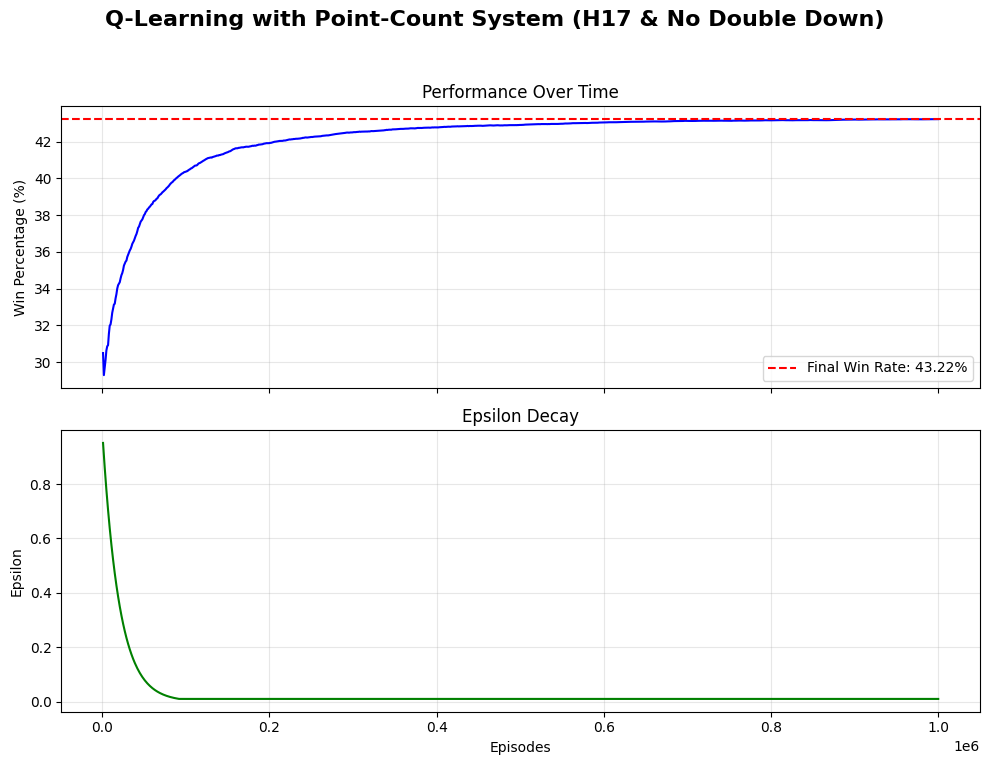

In [ ]:
def run_q_learning_with_variations(num_episodes=1000000):
    """
    Run a Q-Learning simulation for Blackjack with:
    - Point-count system
    - Dealer hits on soft 17 (H17)
    - Double down is not allowed
    Tracks learning performance over time.
    """

    # -----------------------------------------------------------
    # Print header for clarity
    # -----------------------------------------------------------
    title = "Q-Learning with Point-Count System (H17 & No Double Down)"
    print("\n" + "="*70)
    print(title)
    print("="*70)

    # -----------------------------------------------------------
    # Environment setup with *rule variations*
    # Dealer hits on soft 17; player cannot double down
    # -----------------------------------------------------------
    env = BlackjackEnvAdvanced(
        dealer_hits_on_soft_17=True,
        allow_double_down=False
    )

    # -----------------------------------------------------------
    # Hyperparameters & Init
    # -----------------------------------------------------------
    LEARNING_RATE = 0.1      # Alpha: step size
    INITIAL_EPSILON = 1.0    # Start with full exploration
    EPSILON_DECAY = 0.99995  # Gradual decay per episode
    MIN_EPSILON = 0.01       # Minimum exploration floor
    GAMMA = 0.95             # Discount factor

    strategy = ThorpBasicStrategy()  # Used for tie-breaking

    # Q-Table: nested defaultdict mapping (state -> {action: Q-value})
    Q = defaultdict(lambda: defaultdict(float))

    epsilon = INITIAL_EPSILON  # Start exploration high

    # Stats
    wins, losses, draws = 0, 0, 0

    # Logs for plotting
    win_rates, episodes_list, epsilons = [], [], []

    # -----------------------------------------------------------
    # Helper: Get legal actions
    # Note: Double down not allowed -> will always return [0,1]
    # -----------------------------------------------------------
    def get_legal_actions(state):
        return [0, 1, 2] if state[3] else [0, 1]

    # -----------------------------------------------------------
    # Helper: Epsilon-Greedy policy
    # -----------------------------------------------------------
    def epsilon_greedy_action(state, Q_table, eps, strat):
        legal_actions = get_legal_actions(state)

        # With probability epsilon -> random
        if random.random() < eps:
            return random.choice(legal_actions)

        # Else pick best known action
        q_vals = {action: Q_table[state][action] for action in legal_actions}
        max_q = max(q_vals.values())
        best_actions = [action for action, q in q_vals.items() if q == max_q]

        # Tie-breaker: if multiple best, fallback to strategy
        return best_actions[0] if len(best_actions) == 1 else strat.get_action(state)

    # -----------------------------------------------------------
    # Main Q-Learning loop (off-policy)
    # -----------------------------------------------------------
    for episode in range(num_episodes):
        state = env.reset()  # Reset env
        done = False

        while not done:
            # Pick action
            action = epsilon_greedy_action(state, Q, epsilon, strategy)

            # Take step
            next_state, reward, done = env.step(action)

            # Estimate optimal future Q
            best_next_q = max(
                [Q[next_state][a] for a in get_legal_actions(next_state)]
            ) if not done else 0

            # Q-Learning update
            Q[state][action] += LEARNING_RATE * (
                reward + GAMMA * best_next_q - Q[state][action]
            )

            state = next_state

        # Track win/loss/draw
        if reward > 0:
            wins += 1
        elif reward < 0:
            losses += 1
        else:
            draws += 1

        # Epsilon decay
        epsilon = max(MIN_EPSILON, epsilon * EPSILON_DECAY)

        # Log every 1000 episodes
        if (episode + 1) % 1000 == 0:
            win_rate = wins / (episode + 1) * 100
            win_rates.append(win_rate)
            episodes_list.append(episode + 1)
            epsilons.append(epsilon)

    # -----------------------------------------------------------
    # Results & Plotting
    # -----------------------------------------------------------
    total_games = wins + losses + draws

    win_p = (wins / total_games) * 100 if total_games > 0 else 0
    loss_p = (losses / total_games) * 100 if total_games > 0 else 0
    draw_p = (draws / total_games) * 100 if total_games > 0 else 0

    print("\nFINAL RESULTS:")
    print(f"Wins: {wins} ({win_p:.2f}%) | Losses: {losses} ({loss_p:.2f}%) | Draws: {draw_p:.2f}%)")

    # Make plots
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 8), sharex=True)
    fig.suptitle(title, fontsize=16, fontweight='bold')

    # Win rate trend
    ax1.plot(episodes_list, win_rates, color='b')
    ax1.axhline(y=win_p, color='r', linestyle='--', label=f'Final Win Rate: {win_p:.2f}%')
    ax1.set(ylabel='Win Percentage (%)', title='Performance Over Time')
    ax1.grid(True, alpha=0.3)
    ax1.legend()

    # Epsilon decay
    ax2.plot(episodes_list, epsilons, color='g')
    ax2.set(xlabel='Episodes', ylabel='Epsilon', title='Epsilon Decay')
    ax2.grid(True, alpha=0.3)

    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()


# -----------------------------------------------------------
# Run the Q-Learning variation
# -----------------------------------------------------------
run_q_learning_with_variations()


Complete Point-Count System for SARSA with rule variations


SARSA with Point-Count System (H17 & No Double Down)

FINAL RESULTS:
Wins: 432703 (43.27%) | Losses: 477908 (47.79%) | Draws: 8.94%)


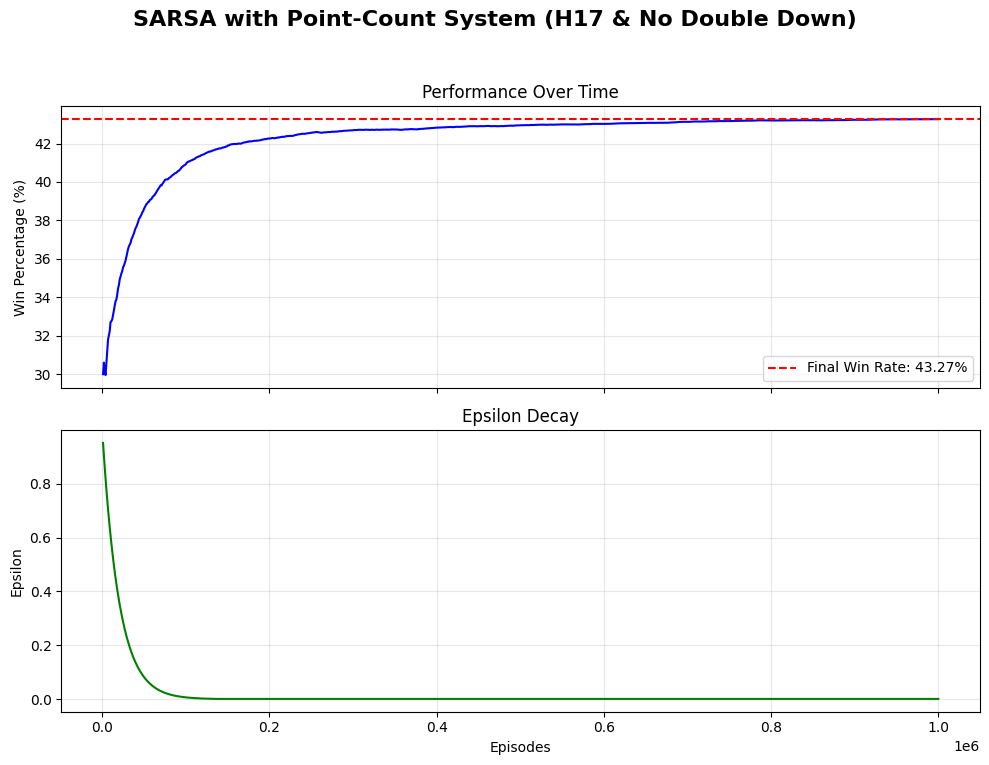

In [ ]:
def run_sarsa_with_variations(num_episodes=1000000):
    """
    Run a SARSA simulation for Blackjack with:
    - Point-count system
    - Dealer hits on soft 17 (H17)
    - Double down is not allowed
    Uses an on-policy TD method to learn an action-value function.
    """


    title = "SARSA with Point-Count System (H17 & No Double Down)"
    print("\n" + "="*70)
    print(title)
    print("="*70)


    # Environment: uses same advanced config
    # Dealer hits soft 17, double down is disallowed

    env = BlackjackEnvAdvanced(
        dealer_hits_on_soft_17=True,
        allow_double_down=False
    )

    # -----------------------------------------------------------
    # Hyperparameters & Init
    # -----------------------------------------------------------
    LEARNING_RATE = 0.1      # Alpha
    INITIAL_EPSILON = 1.0    # Start fully exploring
    EPSILON_DECAY = 0.99995  # Slow decay
    MIN_EPSILON = 0.01       # Min exploration
    GAMMA = 0.95             # Discount

    strategy = ThorpBasicStrategy()  # Tie-breaker for policy

    # Q-Table: nested dict mapping (state) -> {action: Q}
    Q = defaultdict(lambda: defaultdict(float))

    epsilon = INITIAL_EPSILON

    # Track stats
    wins, losses, draws = 0, 0, 0
    win_rates, episodes_list, epsilons = [], [], []

    # -----------------------------------------------------------
    # Helper: Legal actions
    # -----------------------------------------------------------
    def get_legal_actions(state):
        return [0, 1, 2] if state[3] else [0, 1]

    # Helper: Epsilon-greedy policy
    def epsilon_greedy_action(state, Q_table, eps, strat):
        legal_actions = get_legal_actions(state)
        if random.random() < eps:
            return random.choice(legal_actions)
        q_vals = {a: Q_table[state][a] for a in legal_actions}
        max_q = max(q_vals.values())
        best_actions = [a for a, q in q_vals.items() if q == max_q]
        return best_actions[0] if len(best_actions) == 1 else strat.get_action(state)

    # Main SARSA loop (on-policy)

    for episode in range(num_episodes):
        state = env.reset()
        action = epsilon_greedy_action(state, Q, epsilon, strategy)
        done = False

        while not done:
            # Take step
            next_state, reward, done = env.step(action)

            # Next action chosen by current policy
            next_action = epsilon_greedy_action(next_state, Q, epsilon, strategy)

            # SARSA update: uses Q of next action actually chosen
            target_q = Q[next_state][next_action] if not done else 0
            Q[state][action] += LEARNING_RATE * (
                reward + GAMMA * target_q - Q[state][action]
            )

            # Move to next
            state, action = next_state, next_action

        # Track outcome
        if reward > 0:
            wins += 1
        elif reward < 0:
            losses += 1
        else:
            draws += 1

        # Epsilon decay
        epsilon = max(MIN_EPSILON, epsilon * EPSILON_DECAY)

        # Log every 1000
        if (episode + 1) % 1000 == 0:
            win_rates.append(wins / (episode + 1) * 100)
            episodes_list.append(episode + 1)
            epsilons.append(epsilon)

    # Results & Plotting

    total_games = wins + losses + draws
    win_p = (wins / total_games) * 100 if total_games > 0 else 0
    loss_p = (losses / total_games) * 100 if total_games > 0 else 0
    draw_p = (draws / total_games) * 100 if total_games > 0 else 0

    print("\nFINAL RESULTS:")
    print(f"Wins: {wins} ({win_p:.2f}%) | Losses: {losses} ({loss_p:.2f}%) | Draws: {draw_p:.2f}%)")

    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 8), sharex=True)
    fig.suptitle(title, fontsize=16, fontweight='bold')

    # Win rate plot
    ax1.plot(episodes_list, win_rates, color='b')
    ax1.axhline(y=win_p, color='r', linestyle='--', label=f'Final Win Rate: {win_p:.2f}%')
    ax1.set(ylabel='Win Percentage (%)', title='Performance Over Time')
    ax1.grid(True, alpha=0.3)
    ax1.legend()

    # Epsilon plot
    ax2.plot(episodes_list, epsilons, color='g')
    ax2.set(xlabel='Episodes', ylabel='Epsilon', title='Epsilon Decay')
    ax2.grid(True, alpha=0.3)

    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()



# Run SARSA variation

run_sarsa_with_variations()


--------------------------------------THE END---------------------